# Narongkrit Khieopraphatsorn ID: 3975261346

# HW4_INF 552

#### Disclaimer: This set of homework applies SMOTE to a seriously imbalanced dataset with a large number of features and data points. SMOTE is essentially a time consuming method. You need to start doing this homework early, so that you have enough time to run SMOTE on the full dataset.

## 1. The LASSO and Boosting for Regression

### (a) Download the Communities and Crime data1 from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as the training set and the rest as the test set.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("communities.csv",header=None)

In [3]:
df.drop([0,1,2,3,4], axis=1, inplace=True)

In [4]:
df.columns = [i-5 for i in range(5,128)]

In [5]:
df.replace("?", np.nan,inplace=True)

### (b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [6]:
for i in df.columns:
    df[i] = df[i].astype('float64')
    mean_tmp = df[i].mean()
    df[i].fillna(mean_tmp,inplace=True)

In [7]:
train_df = df.iloc[0:1495]
test_df = df.iloc[1495:]

In [8]:
X = df.iloc[:,:-1]
y = df[122]
X_train = train_df.iloc[:,:-1]
y_train = train_df[122]
X_test = test_df.iloc[:,:-1]
y_test = test_df[122]

#### I impute data using mean values.

### (c) Plot a correlation matrix for the features in the data set.

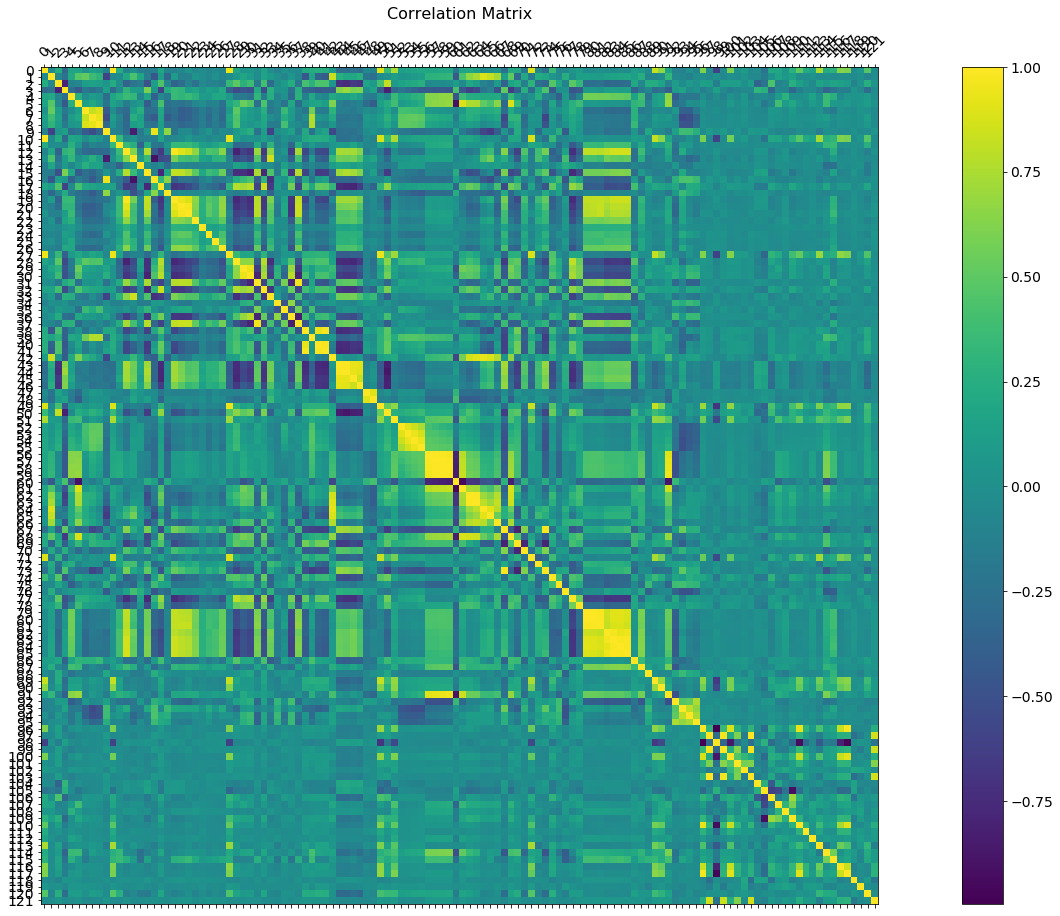

In [9]:
f = plt.figure(figsize=(30, 15))
plt.matshow(X_train.corr(), fignum=f.number)
plt.xticks(range(X_train.shape[1]), X_train.columns, fontsize=14, rotation=45)
plt.yticks(range(X_train.shape[1]), X_train.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

### (d) Calculate the Coefficient of Variation CV for each feature, where CV = s , in which s is sample standard deviation and m is sample mean.

In [9]:
coef_var = pd.DataFrame(columns=["CV"])

In [10]:
for i in X_train.columns:
    coef_var.loc[i] = [X_train[i].std(ddof = 0) / X_train[i].mean()]

In [11]:
coef_var

CV
0    2.240355
1    0.355681
2    1.428407
3    0.330102
4    1.358645
5    1.611552
6    0.368960
7    0.291217
8    0.500143
9    0.412638
10   2.037780
11   0.643103
12   0.591780
13   0.328504
14   0.701663
15   0.365212
16   0.360595
17   0.705970
18   0.345305
19   0.540489
20   0.557893
21   0.519655
22   0.599140
23   0.818094
24   0.614660
25   0.672992
26   0.483906
27   2.341660
28   0.754218
29   0.680263
..        ...
92   0.336132
93   0.334407
94   0.318651
95   0.298334
96   0.871961
97   0.288337
98   0.063981
99   0.244920
100  0.697294
101  0.309319
102  0.226284
103  0.288303
104  0.133692
105  0.122541
106  0.447069
107  0.594754
108  0.725986
109  0.356122
110  0.688579
111  0.143485
112  0.308784
113  1.644857
114  0.864210
115  1.396642
116  0.539642
117  0.774085
118  0.117949
119  0.370877
120  2.552092
121  0.319928

[122 rows x 1 columns]

### (e) Pick floor(√128) features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

In [21]:
128 ** 0.5

11.313708498984761

In [22]:
sorted_cv = coef_var.sort_values("CV",ascending=False).iloc[0:11]
sig_index = sorted(list(sorted_cv.index))

In [23]:
X_train_sig = X_train[sig_index]

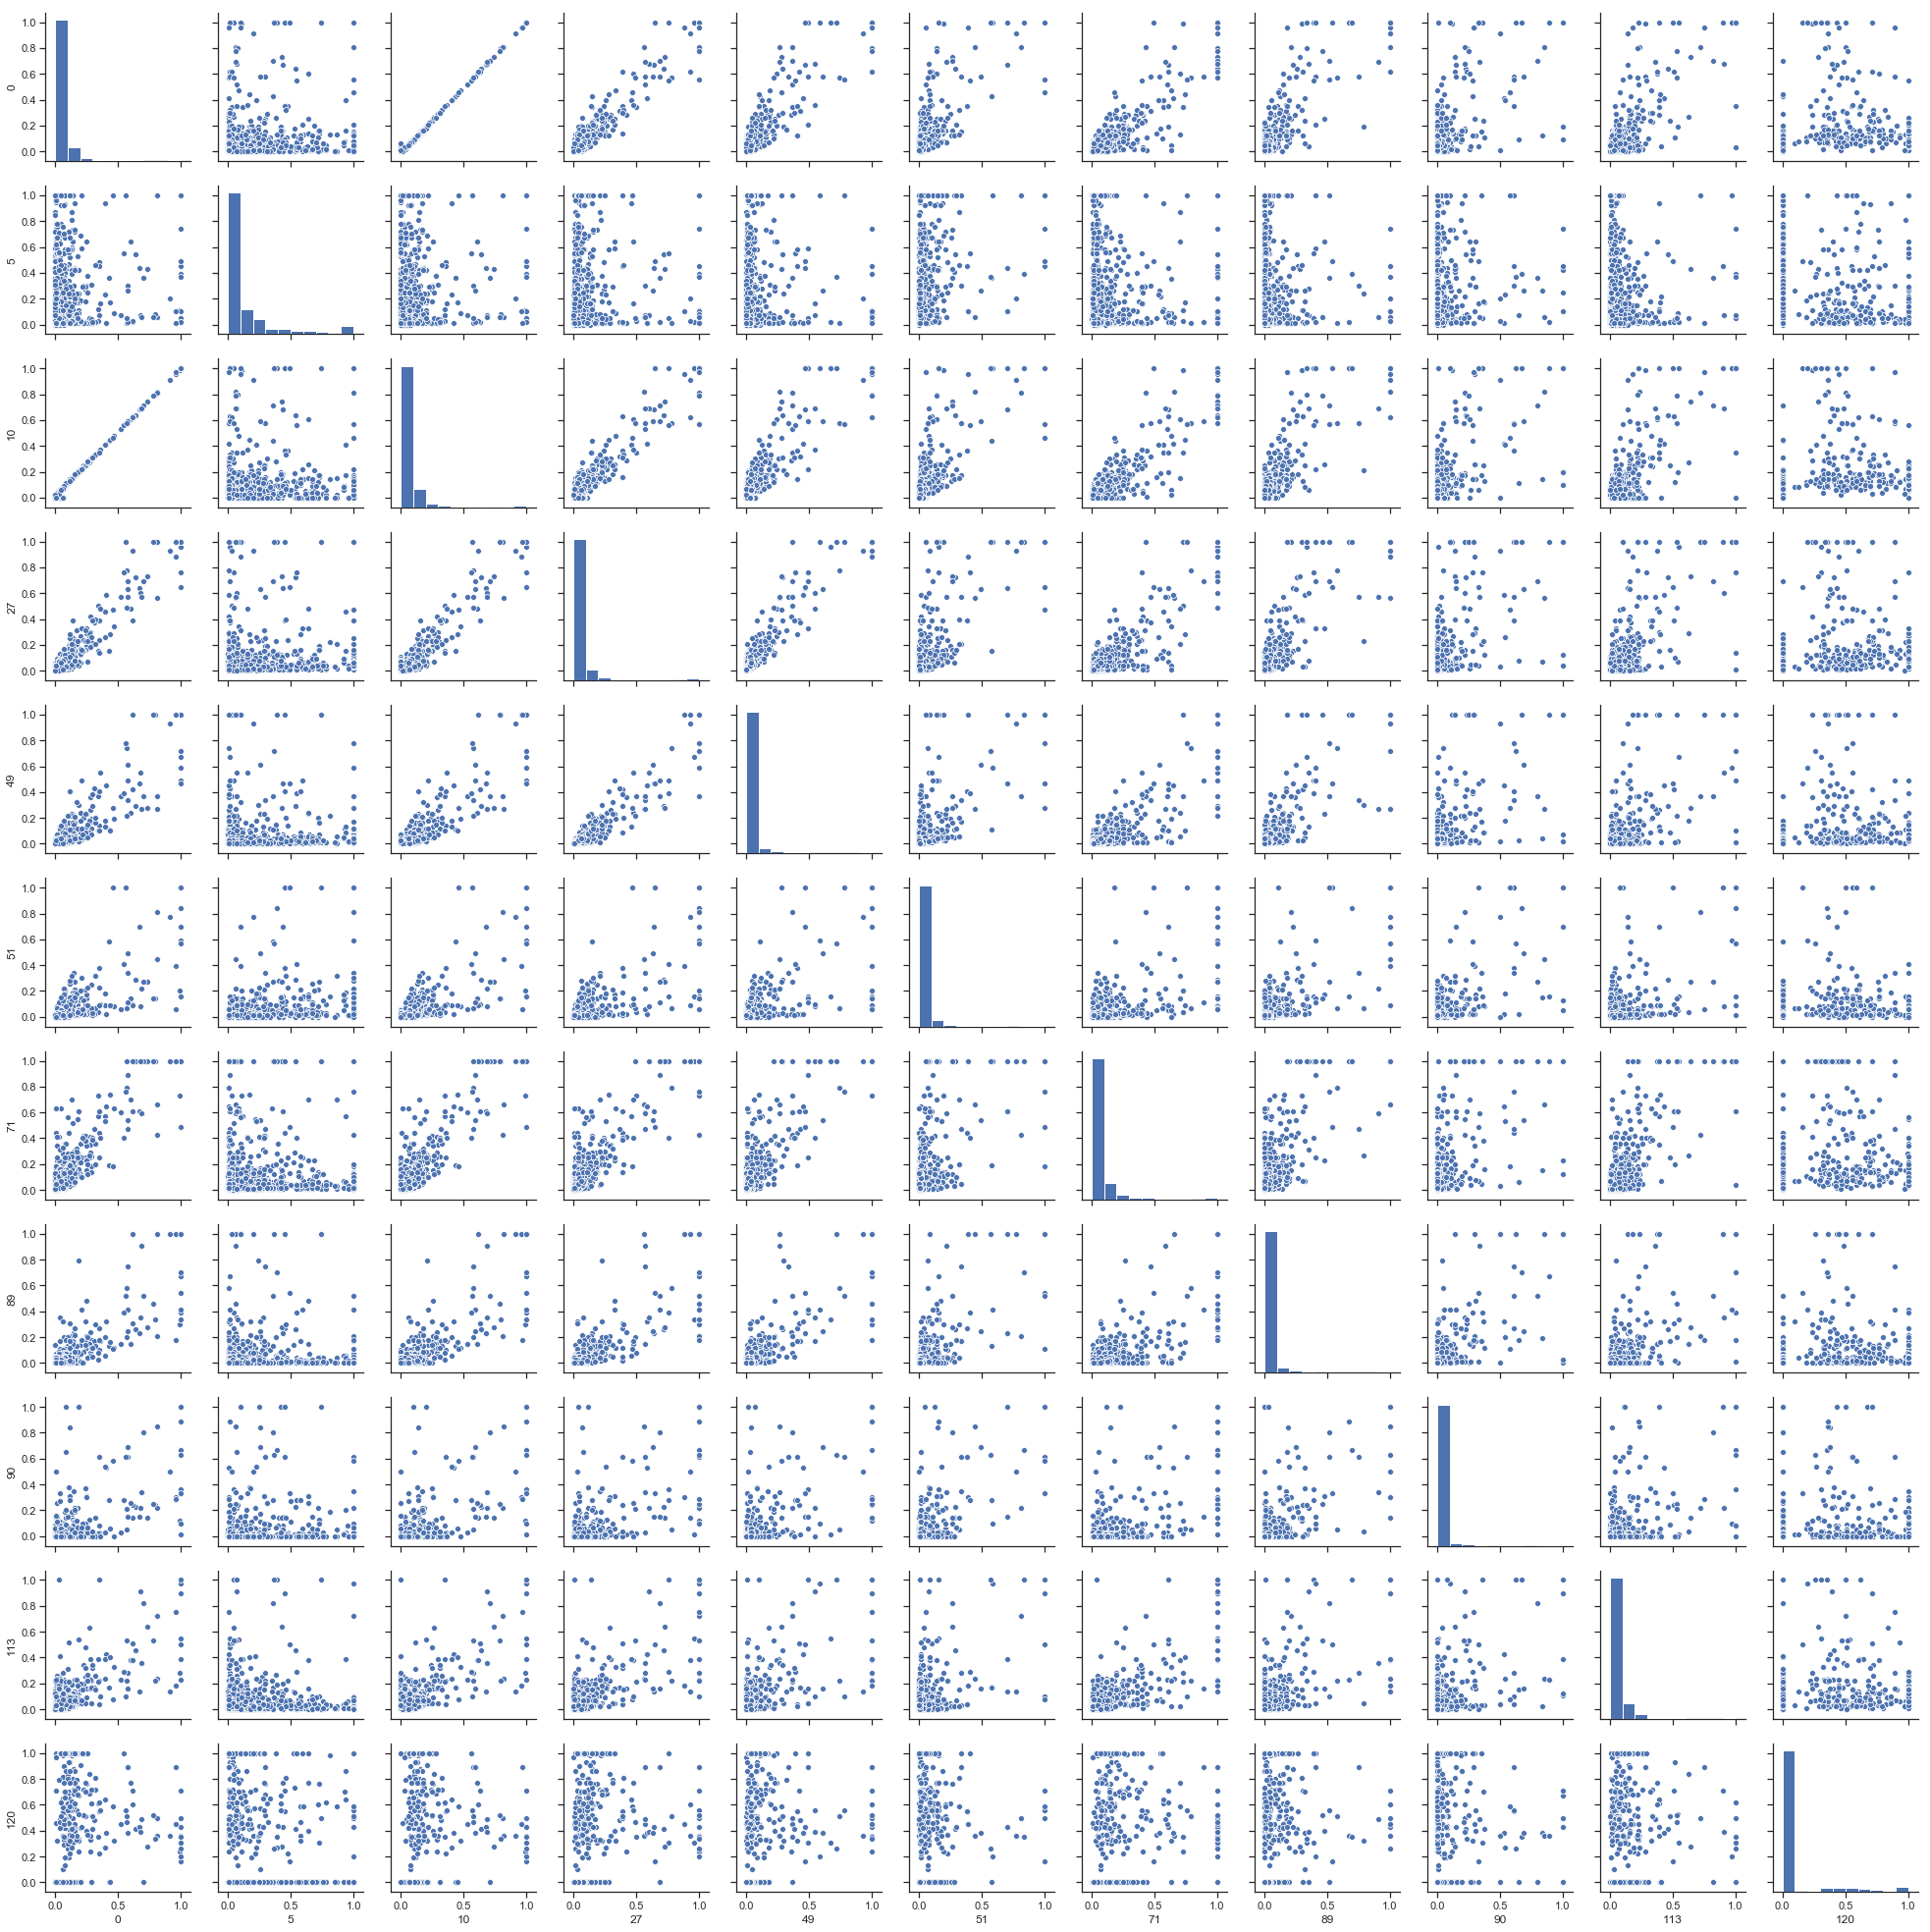

In [16]:
sns.set(style = "ticks", color_codes=True)
g = sns.pairplot(X_train_sig)

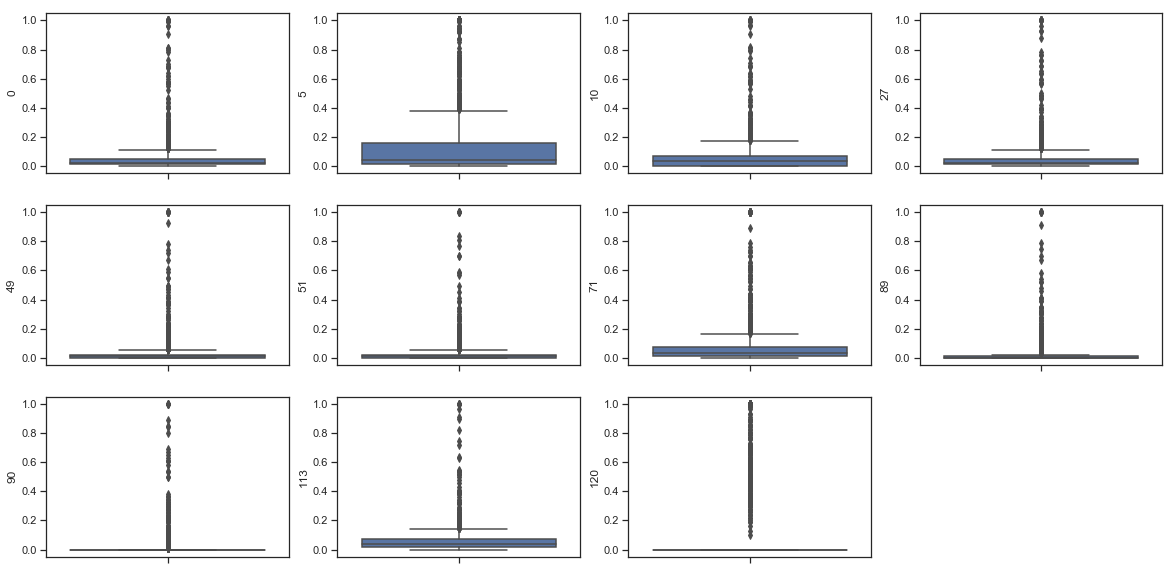

In [17]:
plt.figure(figsize=(20,10))

for i,var in enumerate(X_train_sig.columns):
    plt.subplot(3,4,i+1)
    sns.boxplot(y=var , data=X_train_sig)

#### No, to check the significance we have to choose p-values only.

### (f) Fit a linear model using least squares to the training set and report the test error.

In [24]:
X_test_sig = X_test[sig_index]
lm = LinearRegression()
lm.fit(X_train,y_train)
pred = lm.predict(X_test)
lm_mse = metrics.mean_squared_error(pred,y_test)
print("For test error, MSE =",lm_mse)

For test error, MSE = 0.7897255274190367


### (g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [19]:
RCV = RidgeCV(cv=5)
RCV.fit(X_train,y_train)
pred_rcv = RCV.predict(X_test)
rcv_mse = metrics.mean_squared_error(pred_rcv,y_test)
print("For test error, MSE =",rcv_mse)

For test error, MSE = 0.01773708110430366


### (h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

In [20]:
LCV = LassoCV(cv=5)
LCV.fit(X_train,y_train)
pred_lcv = LCV.predict(X_test)
lcv_mse = metrics.mean_squared_error(pred_lcv,y_test)
print("For test error, MSE =",lcv_mse)
lcv_coef = np.array(LCV.coef_)
print("Variables selected: ",X_train.columns[lcv_coef != 0])

For test error, MSE = 0.017763310017858244
Variables selected:  Int64Index([  2,   4,   6,   7,  11,  13,  14,  15,  16,  17,  18,  21,  22,
             23,  24,  25,  26,  28,  29,  33,  34,  36,  38,  39,  40,  44,
             45,  46,  48,  49,  50,  51,  55,  59,  61,  63,  64,  67,  68,
             69,  70,  71,  72,  74,  75,  76,  77,  78,  79,  82,  85,  86,
             87,  88,  89,  90,  91,  92,  94,  99, 100, 102, 104, 106, 108,
            110, 111, 112, 113, 114, 115, 118, 119, 120, 121],
           dtype='int64')


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [14]:
std_train_df = StandardScaler().fit_transform(X_train)
std_test_df = StandardScaler().fit_transform(X_test)
LCV = LassoCV(cv=5)
LCV.fit(std_train_df,y_train)
pred_lcv = LCV.predict(std_test_df)
lcv_mse = metrics.mean_squared_error(pred_lcv,y_test)
print("For test error, MSE =",lcv_mse)
lcv_coef = np.array(LCV.coef_)
print("Variables selected: ",X_train.columns[lcv_coef != 0])

For test error, MSE = 0.017998418592939717
Variables selected:  Int64Index([  2,   4,   6,   7,  11,  13,  14,  15,  16,  17,  18,  21,  22,
             23,  24,  25,  26,  28,  29,  33,  34,  38,  39,  40,  44,  45,
             46,  48,  49,  50,  51,  53,  55,  59,  61,  63,  64,  67,  68,
             69,  71,  72,  74,  75,  76,  77,  78,  82,  85,  86,  87,  88,
             89,  90,  91,  94,  99, 100, 102, 104, 105, 106, 107, 108, 110,
            111, 112, 113, 114, 115, 116, 118, 119],
           dtype='int64')


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/pyth

#### This LassoCV model works on normal features better than Standardized features since normal features has lower error than standardized features.

### (i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained

In [25]:
M = 0
error = 1000
for i in range(1,len(X_train.columns)):
    pca = PCA(n_components=i)
    pca_X = pca.fit_transform(std_train_df)
    scores = cross_val_score(lm,pca_X, y_train,cv = 5,scoring='neg_mean_squared_error')
    if error > abs(scores.mean()):
        M = i
        error = abs(scores.mean())

In [26]:
print("Choosing M =" ,M)

Choosing M = 95


In [27]:
pca = PCA(n_components=95)
pca_X_train = pca.fit_transform(std_train_df)
pca_X_test = pca.fit_transform(std_test_df)
lm.fit(pca_X_train,y_train)
pred = lm.predict(pca_X_test)
pca_mse = metrics.mean_squared_error(pred,y_test)
print("For test error, MSE =",pca_mse,"with M:",M)

For test error, MSE = 0.04642269498154766 with M: 95


### (j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation.


In [16]:
alpha = 0
error = []
for i in [0.01,0.1,1,10,100]:
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',reg_alpha=i,reg_lambda=0)
    scores = cross_val_score(xg_reg,X_train, y_train,cv = 5,scoring='neg_mean_squared_error')
    error.append(abs(scores.mean()))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is

In [17]:
for er, al in zip(error,[0.01,0.1,1,10,100]):
    print("Alpha is:",al,"with error",er)

Alpha is: 0.01 with error 0.02033881079304973
Alpha is: 0.1 with error 0.02031171611827649
Alpha is: 1 with error 0.02004687996936797
Alpha is: 10 with error 0.021549259640142933
Alpha is: 100 with error 0.03765181913264615


In [18]:
min_error = min(error)
min_alpha = [0.01,0.1,1,10,100][error.index(min_error)]
print("alpha is",min_alpha,"with error:",min_error)

alpha is 1 with error: 0.02004687996936797


### 2. Tree-Based Methods

### (a) Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks . The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

In [28]:
df_train_2 = pd.read_csv("aps_failure_training_set.csv",header=14)
df_test_2 = pd.read_csv("aps_failure_test_set.csv",header=14)

### (b) Data Preparation
### This data set has missing values. When the number of data with missing values is significant, discarding them is not a good idea. 
### i. Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.

In [29]:
df_train_2.replace("na", np.nan,inplace=True)
df_test_2.replace("na", np.nan,inplace=True)

In [30]:
for i in df_train_2.columns[1:]:
    df_train_2[i] = df_train_2[i].astype('float64')
    mean_tmp = df_train_2[i].mean()
    df_train_2[i].fillna(mean_tmp,inplace=True)

In [31]:
for i in df_test_2.columns[1:]:
    df_test_2[i] = df_test_2[i].astype('float64')
    mean_tmp = df_test_2[i].mean()
    df_test_2[i].fillna(mean_tmp,inplace=True)

In [32]:
df_2 = df_train_2.append(df_test_2,sort=False,ignore_index=True)

### ii. For each of the 170 features, calculate the coefficient of variation CV = s/m where s is sample standard deviation and m is sample mean.

In [33]:
X_2 = df_2.iloc[:,1:]
y_2 = df_2.iloc[:,0]
X_train_2 = df_train_2.iloc[:,1:]
y_train_2 = df_train_2.iloc[:,0]
X_test_2 = df_test_2.iloc[:,1:]
y_test_2 = df_test_2.iloc[:,0]

In [34]:
coef_var_2 = pd.DataFrame(columns=["CV"])

In [35]:
for i in X_train_2.columns:
    coef_var_2.loc[i] = [X_2[i].std(ddof = 0) / X_2[i].mean()]

In [36]:
coef_var_2

CV
aa_000    4.328579
ab_000    2.178383
ac_000    2.167634
ad_000  206.785449
ae_000   22.293851
af_000   18.209242
ag_000   91.464919
ag_001   42.080063
ag_002   17.624811
ag_003    8.753012
ag_004    5.475014
ag_005    2.964193
ag_006    2.352567
ag_007    2.812475
ag_008    6.274932
ag_009   32.166412
ah_000    2.315522
ai_000   18.506454
aj_000   43.144401
ak_000   78.623597
al_000    9.111975
am_0      9.067227
an_000    2.254216
ao_000    2.276094
ap_000    3.085871
aq_000    2.853443
ar_000   10.569303
as_000  113.895150
at_000   23.187039
au_000   86.089780
...            ...
dl_000   37.455829
dm_000   34.552050
dn_000    2.875113
do_000    2.174400
dp_000    2.009299
dq_000   21.186092
dr_000    6.585968
ds_000    2.289939
dt_000    2.165066
du_000    2.796102
dv_000    3.452093
dx_000    5.105308
dy_000    7.516755
dz_000   49.252681
ea_000   32.778335
eb_000    4.541953
ec_00     2.378535
ed_000    2.250521
ee_000    3.369160
ee_001    3.235199
ee_002    2.603581
ee_003    2.573259
ee_004    2.625372
ee_005    2.858213
ee_006    3.230960
ee_007    4.885054
ee_008    3.334997
ee_009    5.753879
ef_000   47.924819
eg_000   45.648216

[170 rows x 1 columns]

### iii. Plot a correlation matrix for your features using pandas or any other tool.

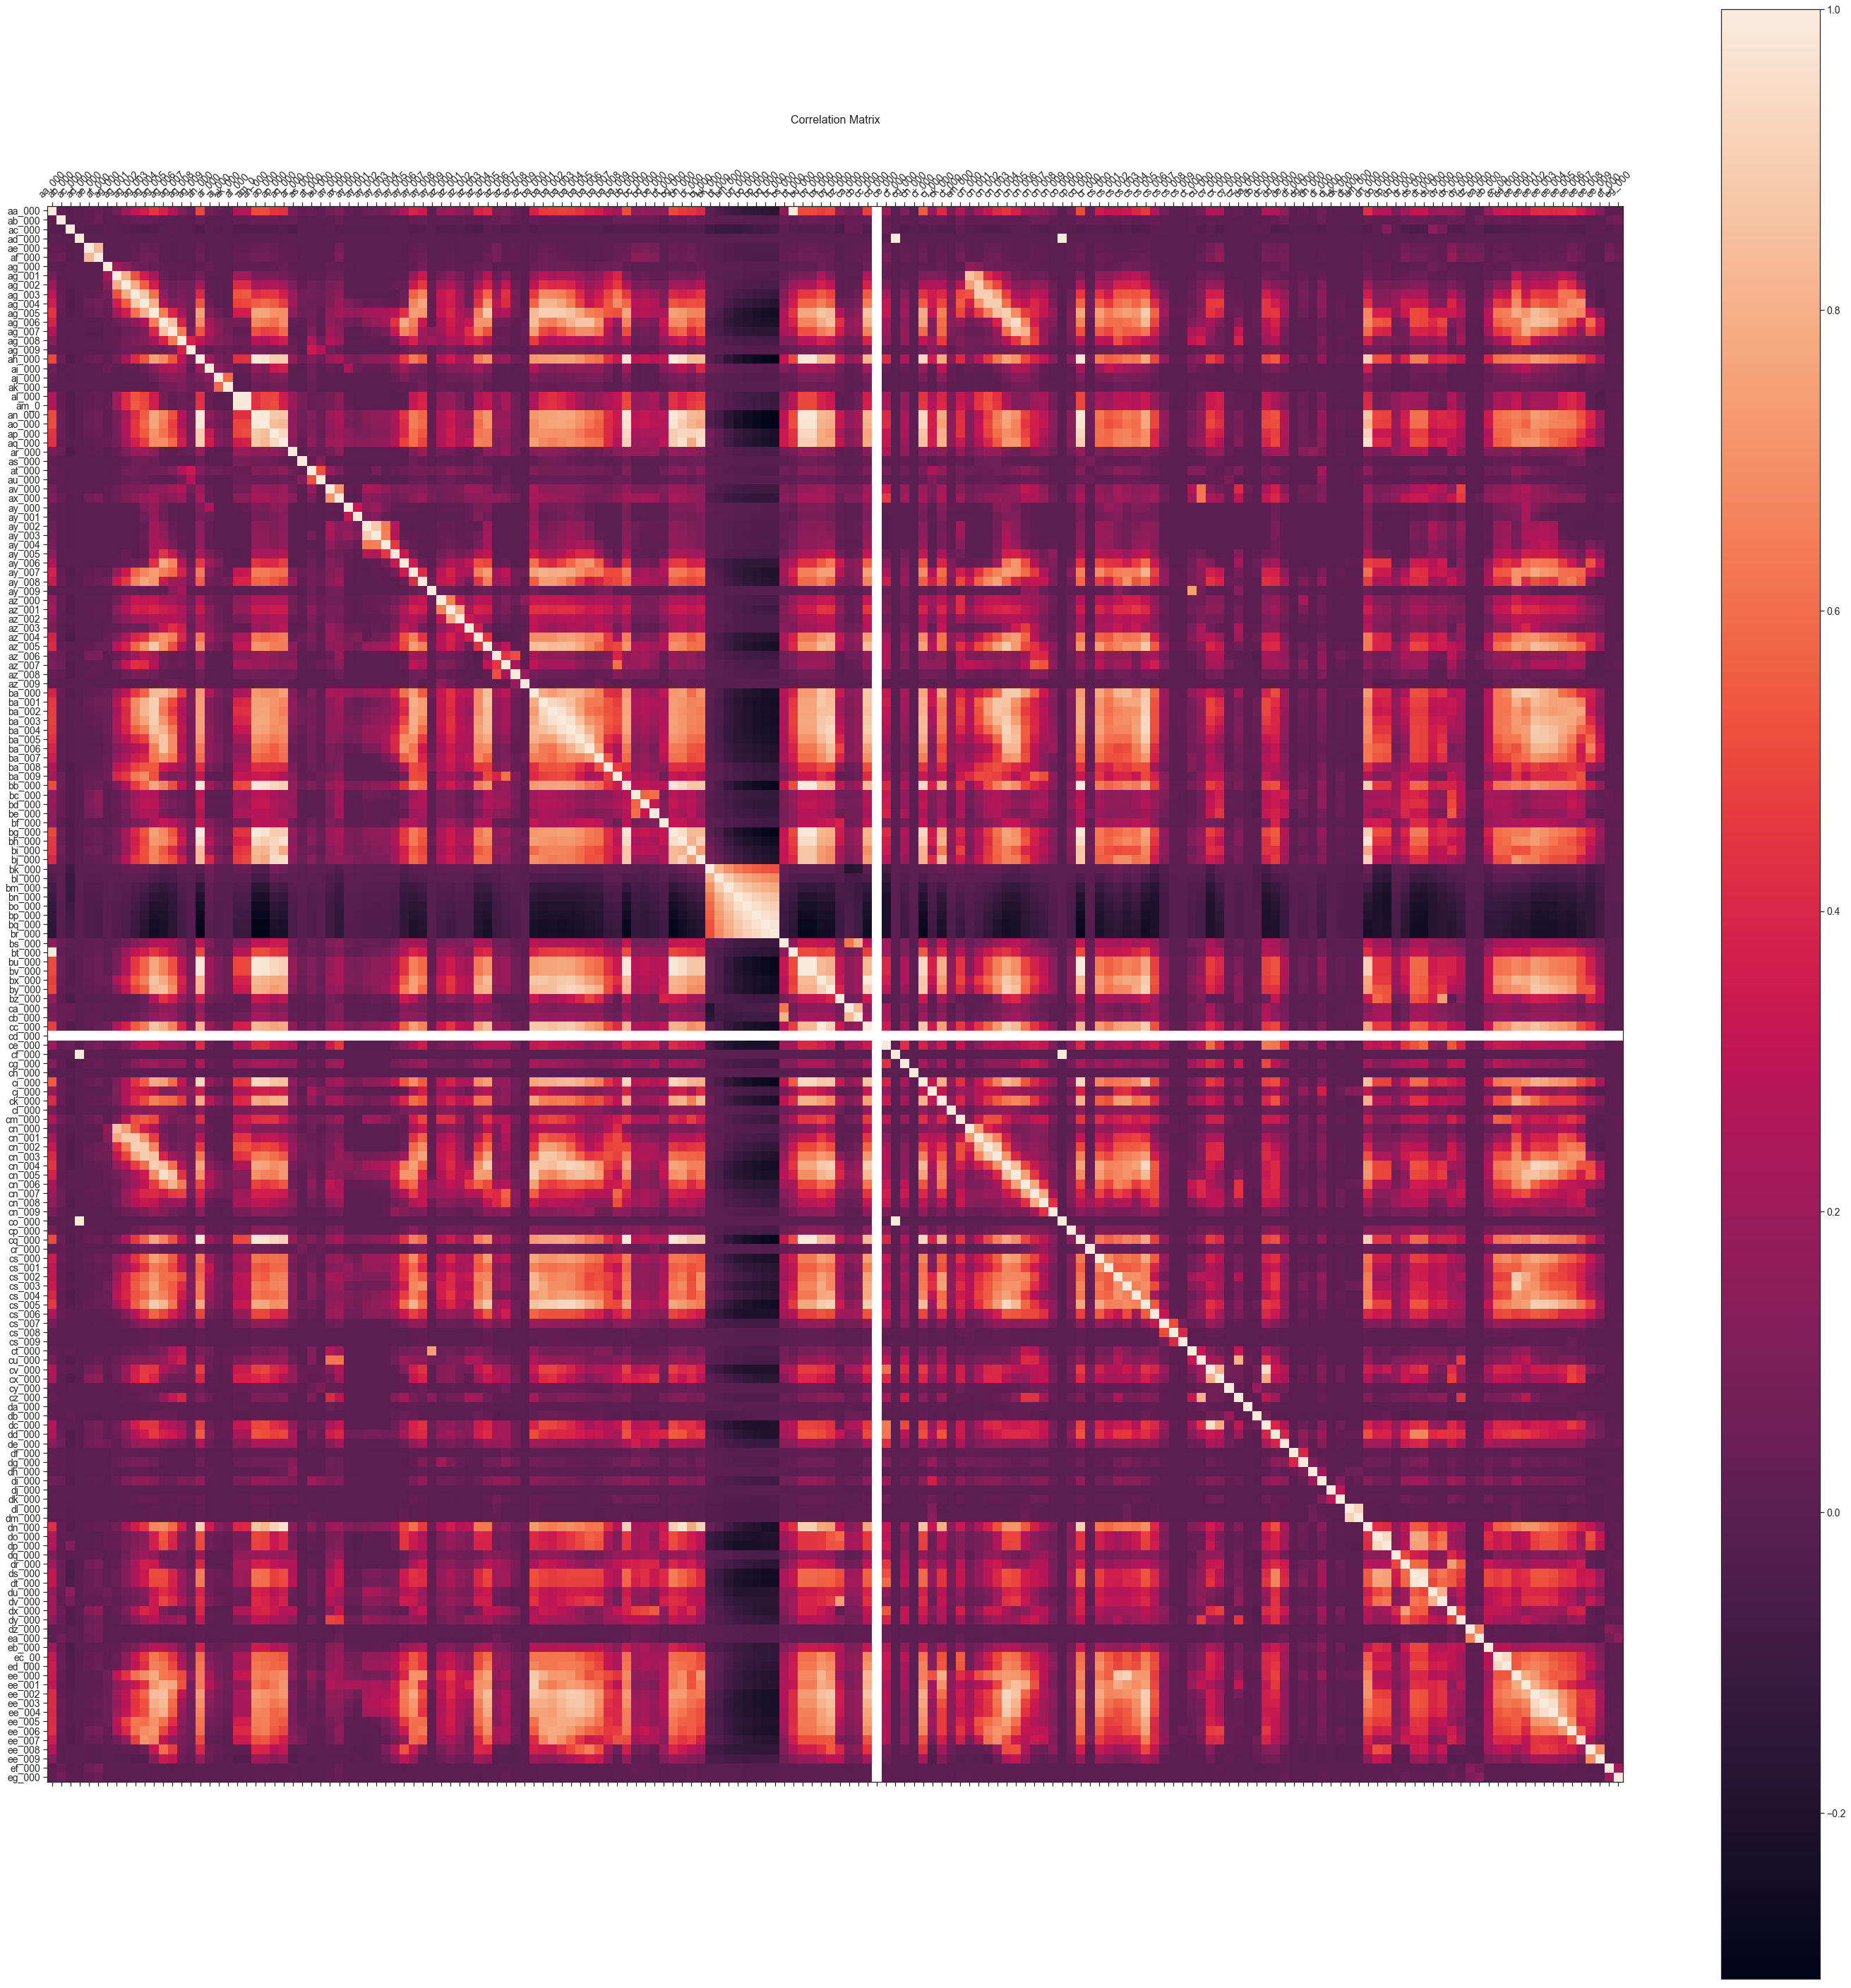

In [36]:
f = plt.figure(figsize=(50, 50))
plt.matshow(X_2.corr(), fignum=f.number)
plt.xticks(range(X_2.shape[1]), X_2.columns, fontsize=14, rotation=45)
plt.yticks(range(X_2.shape[1]), X_2.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

### iv. Pick ⌊ 170⌋ features with highest CV , and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

In [37]:
170 ** 0.5

13.038404810405298

In [38]:
sorted_cv_2 = coef_var_2.sort_values("CV",ascending=False).iloc[0:13]
sig_index_2 = sorted(list(sorted_cv_2.index))

In [39]:
X_sig_2 = X_2[sig_index_2]

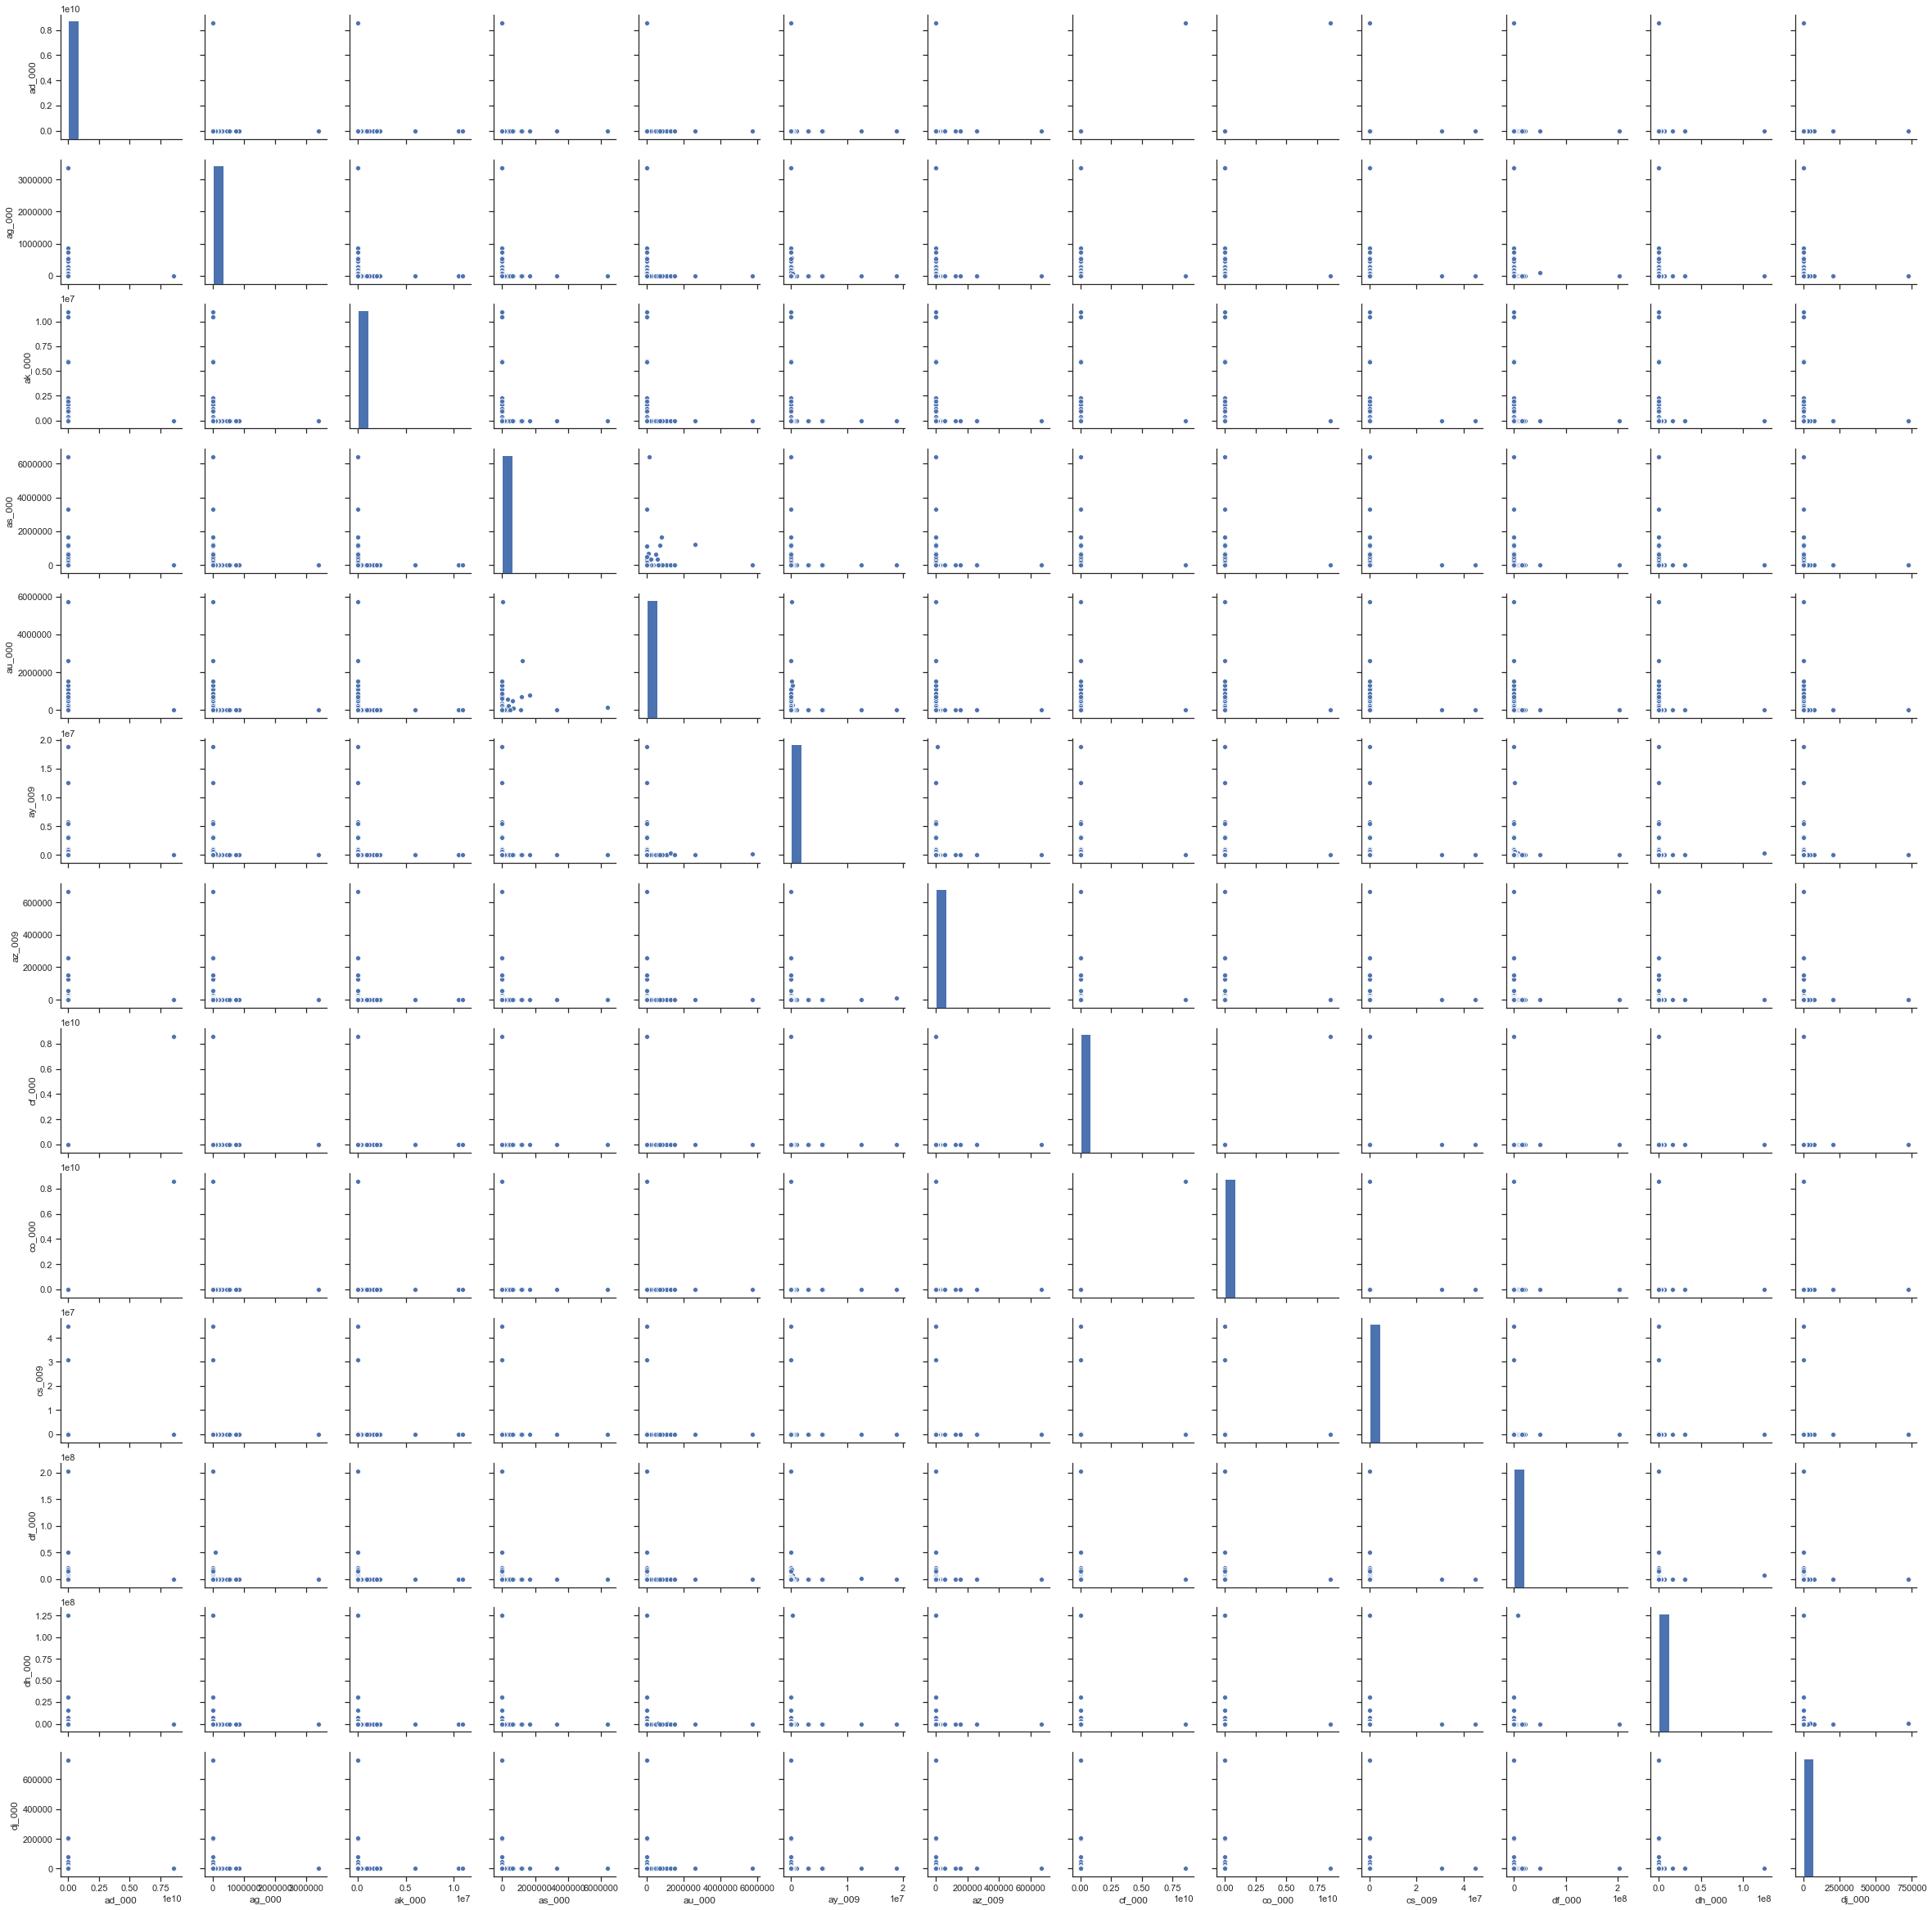

In [40]:
sns.set(style = "ticks", color_codes=True)
g = sns.pairplot(X_sig_2)

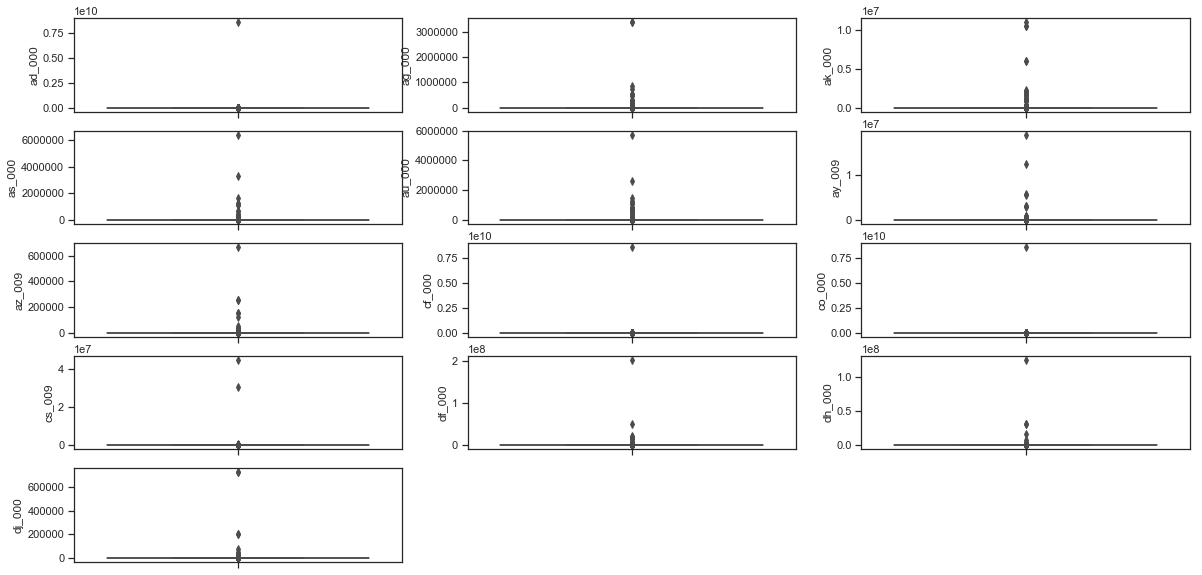

In [41]:
plt.figure(figsize=(20,10))

for i,var in enumerate(X_sig_2.columns):
    plt.subplot(5,3,i+1)
    sns.boxplot(y=var , data=X_sig_2)

#### No, to check the significance we have to choose p-values only.

### v. Determine the number of positive and negative data. Is this data set imbalanced?

In [42]:
y_2[y_2 == "neg"].shape

(74625,)

In [43]:
y_2[y_2 == "pos"].shape

(1375,)

#### For positive train data = 1375 data points, For negative train data = 74625 data points. It's imbalanced

#### negative = 0, postive = 1

In [44]:
y_train_2[y_train_2 == "neg"] = "0" 
y_train_2[y_train_2 == "pos"] = "1" 
y_2[y_2=="neg"] = "0"
y_2[y_2=="pos"] = "1"
y_test_2[y_test_2=="neg"] = "0"
y_test_2[y_test_2=="pos"] = "1"

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-c

### (c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

In [45]:
rand_for = RandomForestClassifier(n_estimators=100, warm_start=True,bootstrap = True, oob_score=True, max_features="sqrt")

#### Predict Training

In [46]:
# y is string

In [47]:
rand_for.fit(X_train_2,y_train_2)
pred = rand_for.predict(X_train_2)

In [48]:
error = 1 - accuracy_score(y_train_2,pred)
print("Error:",error)

Error: 1.666666666666483e-05


In [49]:
confusion_matrix(y_train_2, pred)

array([[59000,     0],
       [    1,   999]])

#### True positive 999, True negative is 59000, False positive is 1, False Negative is 0

In [50]:
# y is numpy

In [51]:
y_train_2[y_train_2 == "0"] = 0 
y_train_2[y_train_2 == "1"] = 1 
y_train_2 = y_train_2.astype("int64")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


AUC: 1.000


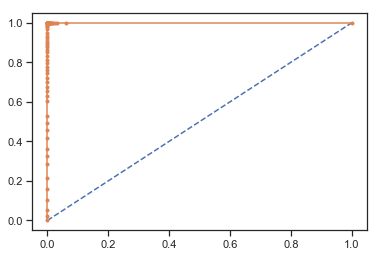

In [52]:
probs = rand_for.predict_proba(X_train_2)[:, 1]
auc = roc_auc_score(np.array(y_train_2), probs)
print('AUC: %.3f' % auc)
fpr, tpr, thresholds = roc_curve(np.array(y_train_2), probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Predict Testing

In [53]:
# y is string

In [54]:
pred = rand_for.predict(X_test_2)

In [55]:
error = 1 - accuracy_score(y_test_2,pred)
print("Error:",error)

Error: 0.0078125


In [56]:
confusion_matrix(y_test_2, pred)

array([[15607,    18],
       [  107,   268]])

#### True positive 268, True negative is 15607, False positive is 107, False Negative is 18

In [57]:
# y is numpy

In [58]:
y_test_2[y_test_2 == "0"] = 0 
y_test_2[y_test_2 == "1"] = 1 
y_test_2 = y_test_2.astype("int64")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


AUC: 0.993


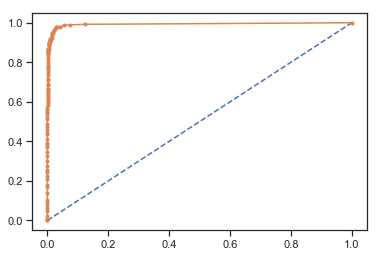

In [59]:
probs = rand_for.predict_proba(X_test_2)[:, 1]
auc = roc_auc_score(np.array(y_test_2), probs)
print('AUC: %.3f' % auc)
fpr, tpr, thresholds = roc_curve(np.array(y_test_2), probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Out-of-bag error estimate

In [60]:
oob_error = 1 - rand_for.oob_score_
print("Out-Of-Bag estimate:",oob_error)

Out-Of-Bag estimate: 0.006099999999999994


#### Out-Of-Bag error is smaller than test error.

### (d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 2c. Compare the results with those of 2c.

In [61]:
df_train_2 = pd.read_csv("aps_failure_training_set.csv",header=14)
df_test_2 = pd.read_csv("aps_failure_test_set.csv",header=14)

In [62]:
df_train_2.replace("na", np.nan,inplace=True)
df_test_2.replace("na", np.nan,inplace=True)

for i in df_train_2.columns[1:]:
    df_train_2[i] = df_train_2[i].astype('float64')
    mean_tmp = df_train_2[i].mean()
    df_train_2[i].fillna(mean_tmp,inplace=True)

for i in df_test_2.columns[1:]:
    df_test_2[i] = df_test_2[i].astype('float64')
    mean_tmp = df_test_2[i].mean()
    df_test_2[i].fillna(mean_tmp,inplace=True)

df_2 = df_train_2.append(df_test_2,sort=False,ignore_index=True)

In [63]:
X_2 = df_2.iloc[:,1:]
y_2 = df_2.iloc[:,0]
X_train_2 = df_train_2.iloc[:,1:]
y_train_2 = df_train_2.iloc[:,0]
X_test_2 = df_test_2.iloc[:,1:]
y_test_2 = df_test_2.iloc[:,0]

In [64]:
smt = SMOTE()
X_smote, y_smote = smt.fit_sample(X_train_2, y_train_2)

In [65]:
y_smote[y_smote == "neg"] = "0" 
y_smote[y_smote == "pos"] = "1" 
y_train_2[y_train_2 == "neg"] = "0" 
y_train_2[y_train_2 == "pos"] = "1" 
y_2[y_2=="neg"] = "0"
y_2[y_2=="pos"] = "1"
y_test_2[y_test_2=="neg"] = "0"
y_test_2[y_test_2=="pos"] = "1"

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pand

In [66]:
# y is string

In [67]:
rand_for.fit(X_smote,y_smote)
pred = rand_for.predict(X_smote)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:308: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


In [68]:
error = 1 - accuracy_score(y_smote,pred)
print("Error:",error)

Error: 0.08551694915254238


In [69]:
confusion_matrix(y_smote, pred)

array([[59000,     0],
       [10091, 48909]])

#### True positive 48909, True negative is 59000, False positive is 10091, False Negative is 0

In [70]:
# y is numpy

In [71]:
y_smote[y_smote == "0"] = 0 
y_smote[y_smote == "1"] = 1 
y_smote = y_smote.astype("int64")

AUC: 0.995


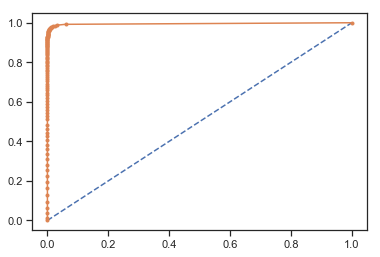

In [72]:
probs = rand_for.predict_proba(X_smote)[:, 1]
auc = roc_auc_score(np.array(y_smote), probs)
print('AUC: %.3f' % auc)
fpr, tpr, thresholds = roc_curve(np.array(y_smote), probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Predict Testing

In [73]:
# y is string

In [74]:
pred = rand_for.predict(X_test_2)

In [75]:
error = 1 - accuracy_score(y_test_2,pred)
print("Error:",error)

Error: 0.0078125


In [76]:
confusion_matrix(y_test_2, pred)

array([[15607,    18],
       [  107,   268]])

#### True positive 268, True negative is 15607, False positive is 107, False Negative is 18

In [77]:
# y is numpy

In [78]:
y_test_2[y_test_2 == "0"] = 0 
y_test_2[y_test_2 == "1"] = 1 
y_test_2 = y_test_2.astype("int64")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


AUC: 0.993


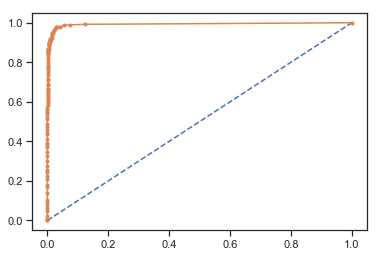

In [79]:
probs = rand_for.predict_proba(X_test_2)[:, 1]
auc = roc_auc_score(np.array(y_test_2), probs)
print('AUC: %.3f' % auc)
fpr, tpr, thresholds = roc_curve(np.array(y_test_2), probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Out-of-bag error estimate

In [80]:
oob_error = 1 - rand_for.oob_score_
print("Out-Of-Bag estimate:",oob_error)

Out-Of-Bag estimate: 0.08933898305084742


#### Compare to 2C, The error for testing looks similar. On the other hand, out-of-bag estimate is bigger since it has a larger number of out-of-bag data points.

### (e) Model Trees
### In the case of a univariate tree, only one input dimension is used at a tree split. In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. In univariate classification trees, majority polling is used at each node to determine the split of that node as the decision rule. In model trees, a (linear) model that relies on all of the variables is used to determine the split of that node (i.e. instead of using Xj > s as the decision rule, one has (Sum j) βjXj > s. as the decision rule). Alternatively, in a regression tree, instead of using average in the region associated with each node, a linear regression model is used to determine the value associated with that node. One of the methods that can be used at each node is Logistic Regression. One can use scikit learn to call Weka to train Logistic Model Trees for classification. 

### Train Logistic Model Trees for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.


In [81]:
import weka.core.jvm as jvm
jvm.start()

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/javabridge/jars/runnablequeue.jar', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/javabridge/jars/cpython.jar', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/weka/lib/python-weka-wrapper.jar', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


In [82]:
from weka.classifiers import Classifier
cls = Classifier(classname="weka.classifiers.trees.LMT")

In [83]:
from weka.core.converters import Loader
loader = Loader(classname="weka.core.converters.ArffLoader")
data = loader.load_file("train_2.arff")

In [84]:
data.class_index = 0

####  try to predict and compare to the original set.

In [85]:
cls.build_classifier(data)
predict_label = []

for index, inst in enumerate(data):
    pred = cls.classify_instance(inst)
    print(str(index) + ": " + "predicted label index=" + str(pred))
    predict_label.append(str(pred))

0: predicted label index=0.0
1: predicted label index=0.0
2: predicted label index=0.0
3: predicted label index=0.0
4: predicted label index=0.0
5: predicted label index=0.0
6: predicted label index=0.0
7: predicted label index=0.0
8: predicted label index=0.0
9: predicted label index=0.0
10: predicted label index=0.0
11: predicted label index=0.0
12: predicted label index=0.0
13: predicted label index=0.0
14: predicted label index=0.0
15: predicted label index=0.0
16: predicted label index=0.0
17: predicted label index=0.0
18: predicted label index=0.0
19: predicted label index=0.0
20: predicted label index=0.0
21: predicted label index=0.0
22: predicted label index=0.0
23: predicted label index=1.0
24: predicted label index=0.0
25: predicted label index=0.0
26: predicted label index=0.0
27: predicted label index=0.0
28: predicted label index=0.0
29: predicted label index=0.0
30: predicted label index=0.0
31: predicted label index=0.0
32: predicted label index=0.0
33: predicted label 

482: predicted label index=0.0
483: predicted label index=0.0
484: predicted label index=1.0
485: predicted label index=0.0
486: predicted label index=0.0
487: predicted label index=0.0
488: predicted label index=0.0
489: predicted label index=0.0
490: predicted label index=0.0
491: predicted label index=0.0
492: predicted label index=0.0
493: predicted label index=0.0
494: predicted label index=0.0
495: predicted label index=0.0
496: predicted label index=0.0
497: predicted label index=0.0
498: predicted label index=0.0
499: predicted label index=0.0
500: predicted label index=0.0
501: predicted label index=0.0
502: predicted label index=0.0
503: predicted label index=0.0
504: predicted label index=0.0
505: predicted label index=0.0
506: predicted label index=0.0
507: predicted label index=0.0
508: predicted label index=0.0
509: predicted label index=0.0
510: predicted label index=0.0
511: predicted label index=0.0
512: predicted label index=0.0
513: predicted label index=0.0
514: pre

792: predicted label index=0.0
793: predicted label index=0.0
794: predicted label index=0.0
795: predicted label index=0.0
796: predicted label index=0.0
797: predicted label index=0.0
798: predicted label index=0.0
799: predicted label index=0.0
800: predicted label index=0.0
801: predicted label index=0.0
802: predicted label index=1.0
803: predicted label index=0.0
804: predicted label index=0.0
805: predicted label index=0.0
806: predicted label index=0.0
807: predicted label index=0.0
808: predicted label index=0.0
809: predicted label index=0.0
810: predicted label index=0.0
811: predicted label index=0.0
812: predicted label index=1.0
813: predicted label index=0.0
814: predicted label index=0.0
815: predicted label index=0.0
816: predicted label index=0.0
817: predicted label index=0.0
818: predicted label index=0.0
819: predicted label index=0.0
820: predicted label index=0.0
821: predicted label index=0.0
822: predicted label index=0.0
823: predicted label index=0.0
824: pre

1366: predicted label index=0.0
1367: predicted label index=0.0
1368: predicted label index=0.0
1369: predicted label index=0.0
1370: predicted label index=0.0
1371: predicted label index=0.0
1372: predicted label index=0.0
1373: predicted label index=0.0
1374: predicted label index=0.0
1375: predicted label index=0.0
1376: predicted label index=0.0
1377: predicted label index=0.0
1378: predicted label index=0.0
1379: predicted label index=0.0
1380: predicted label index=1.0
1381: predicted label index=0.0
1382: predicted label index=0.0
1383: predicted label index=0.0
1384: predicted label index=0.0
1385: predicted label index=0.0
1386: predicted label index=0.0
1387: predicted label index=0.0
1388: predicted label index=0.0
1389: predicted label index=0.0
1390: predicted label index=0.0
1391: predicted label index=0.0
1392: predicted label index=0.0
1393: predicted label index=0.0
1394: predicted label index=0.0
1395: predicted label index=0.0
1396: predicted label index=0.0
1397: pr

1945: predicted label index=0.0
1946: predicted label index=0.0
1947: predicted label index=0.0
1948: predicted label index=0.0
1949: predicted label index=0.0
1950: predicted label index=0.0
1951: predicted label index=0.0
1952: predicted label index=0.0
1953: predicted label index=0.0
1954: predicted label index=0.0
1955: predicted label index=0.0
1956: predicted label index=0.0
1957: predicted label index=0.0
1958: predicted label index=0.0
1959: predicted label index=0.0
1960: predicted label index=0.0
1961: predicted label index=0.0
1962: predicted label index=0.0
1963: predicted label index=0.0
1964: predicted label index=0.0
1965: predicted label index=0.0
1966: predicted label index=0.0
1967: predicted label index=0.0
1968: predicted label index=0.0
1969: predicted label index=0.0
1970: predicted label index=0.0
1971: predicted label index=0.0
1972: predicted label index=0.0
1973: predicted label index=0.0
1974: predicted label index=0.0
1975: predicted label index=0.0
1976: pr

2529: predicted label index=0.0
2530: predicted label index=0.0
2531: predicted label index=0.0
2532: predicted label index=0.0
2533: predicted label index=0.0
2534: predicted label index=0.0
2535: predicted label index=0.0
2536: predicted label index=0.0
2537: predicted label index=0.0
2538: predicted label index=0.0
2539: predicted label index=0.0
2540: predicted label index=0.0
2541: predicted label index=0.0
2542: predicted label index=0.0
2543: predicted label index=0.0
2544: predicted label index=0.0
2545: predicted label index=0.0
2546: predicted label index=0.0
2547: predicted label index=0.0
2548: predicted label index=0.0
2549: predicted label index=0.0
2550: predicted label index=0.0
2551: predicted label index=0.0
2552: predicted label index=0.0
2553: predicted label index=0.0
2554: predicted label index=0.0
2555: predicted label index=0.0
2556: predicted label index=0.0
2557: predicted label index=0.0
2558: predicted label index=0.0
2559: predicted label index=0.0
2560: pr

3103: predicted label index=0.0
3104: predicted label index=0.0
3105: predicted label index=0.0
3106: predicted label index=0.0
3107: predicted label index=0.0
3108: predicted label index=0.0
3109: predicted label index=0.0
3110: predicted label index=0.0
3111: predicted label index=0.0
3112: predicted label index=1.0
3113: predicted label index=0.0
3114: predicted label index=0.0
3115: predicted label index=0.0
3116: predicted label index=0.0
3117: predicted label index=0.0
3118: predicted label index=0.0
3119: predicted label index=0.0
3120: predicted label index=0.0
3121: predicted label index=0.0
3122: predicted label index=0.0
3123: predicted label index=0.0
3124: predicted label index=0.0
3125: predicted label index=0.0
3126: predicted label index=0.0
3127: predicted label index=0.0
3128: predicted label index=0.0
3129: predicted label index=0.0
3130: predicted label index=0.0
3131: predicted label index=0.0
3132: predicted label index=0.0
3133: predicted label index=0.0
3134: pr

3681: predicted label index=0.0
3682: predicted label index=0.0
3683: predicted label index=0.0
3684: predicted label index=0.0
3685: predicted label index=0.0
3686: predicted label index=0.0
3687: predicted label index=0.0
3688: predicted label index=0.0
3689: predicted label index=0.0
3690: predicted label index=0.0
3691: predicted label index=0.0
3692: predicted label index=0.0
3693: predicted label index=0.0
3694: predicted label index=0.0
3695: predicted label index=0.0
3696: predicted label index=0.0
3697: predicted label index=0.0
3698: predicted label index=0.0
3699: predicted label index=0.0
3700: predicted label index=0.0
3701: predicted label index=0.0
3702: predicted label index=0.0
3703: predicted label index=0.0
3704: predicted label index=0.0
3705: predicted label index=0.0
3706: predicted label index=0.0
3707: predicted label index=0.0
3708: predicted label index=0.0
3709: predicted label index=0.0
3710: predicted label index=0.0
3711: predicted label index=0.0
3712: pr

4264: predicted label index=0.0
4265: predicted label index=0.0
4266: predicted label index=0.0
4267: predicted label index=0.0
4268: predicted label index=0.0
4269: predicted label index=0.0
4270: predicted label index=0.0
4271: predicted label index=0.0
4272: predicted label index=0.0
4273: predicted label index=0.0
4274: predicted label index=0.0
4275: predicted label index=0.0
4276: predicted label index=0.0
4277: predicted label index=0.0
4278: predicted label index=0.0
4279: predicted label index=0.0
4280: predicted label index=0.0
4281: predicted label index=0.0
4282: predicted label index=0.0
4283: predicted label index=0.0
4284: predicted label index=0.0
4285: predicted label index=0.0
4286: predicted label index=0.0
4287: predicted label index=0.0
4288: predicted label index=0.0
4289: predicted label index=0.0
4290: predicted label index=0.0
4291: predicted label index=0.0
4292: predicted label index=0.0
4293: predicted label index=0.0
4294: predicted label index=0.0
4295: pr

4829: predicted label index=0.0
4830: predicted label index=0.0
4831: predicted label index=0.0
4832: predicted label index=0.0
4833: predicted label index=0.0
4834: predicted label index=0.0
4835: predicted label index=0.0
4836: predicted label index=0.0
4837: predicted label index=0.0
4838: predicted label index=0.0
4839: predicted label index=0.0
4840: predicted label index=0.0
4841: predicted label index=0.0
4842: predicted label index=0.0
4843: predicted label index=1.0
4844: predicted label index=0.0
4845: predicted label index=0.0
4846: predicted label index=0.0
4847: predicted label index=0.0
4848: predicted label index=0.0
4849: predicted label index=0.0
4850: predicted label index=0.0
4851: predicted label index=1.0
4852: predicted label index=0.0
4853: predicted label index=0.0
4854: predicted label index=0.0
4855: predicted label index=0.0
4856: predicted label index=0.0
4857: predicted label index=0.0
4858: predicted label index=0.0
4859: predicted label index=0.0
4860: pr

5396: predicted label index=0.0
5397: predicted label index=0.0
5398: predicted label index=0.0
5399: predicted label index=0.0
5400: predicted label index=0.0
5401: predicted label index=0.0
5402: predicted label index=0.0
5403: predicted label index=0.0
5404: predicted label index=0.0
5405: predicted label index=0.0
5406: predicted label index=0.0
5407: predicted label index=0.0
5408: predicted label index=0.0
5409: predicted label index=0.0
5410: predicted label index=0.0
5411: predicted label index=0.0
5412: predicted label index=0.0
5413: predicted label index=0.0
5414: predicted label index=0.0
5415: predicted label index=0.0
5416: predicted label index=0.0
5417: predicted label index=0.0
5418: predicted label index=0.0
5419: predicted label index=0.0
5420: predicted label index=0.0
5421: predicted label index=0.0
5422: predicted label index=0.0
5423: predicted label index=0.0
5424: predicted label index=0.0
5425: predicted label index=0.0
5426: predicted label index=0.0
5427: pr

5968: predicted label index=0.0
5969: predicted label index=0.0
5970: predicted label index=0.0
5971: predicted label index=0.0
5972: predicted label index=0.0
5973: predicted label index=0.0
5974: predicted label index=0.0
5975: predicted label index=0.0
5976: predicted label index=0.0
5977: predicted label index=0.0
5978: predicted label index=0.0
5979: predicted label index=0.0
5980: predicted label index=0.0
5981: predicted label index=0.0
5982: predicted label index=0.0
5983: predicted label index=0.0
5984: predicted label index=0.0
5985: predicted label index=0.0
5986: predicted label index=0.0
5987: predicted label index=0.0
5988: predicted label index=0.0
5989: predicted label index=0.0
5990: predicted label index=0.0
5991: predicted label index=0.0
5992: predicted label index=0.0
5993: predicted label index=0.0
5994: predicted label index=0.0
5995: predicted label index=0.0
5996: predicted label index=0.0
5997: predicted label index=0.0
5998: predicted label index=0.0
5999: pr

6510: predicted label index=0.0
6511: predicted label index=0.0
6512: predicted label index=0.0
6513: predicted label index=0.0
6514: predicted label index=0.0
6515: predicted label index=0.0
6516: predicted label index=0.0
6517: predicted label index=0.0
6518: predicted label index=0.0
6519: predicted label index=0.0
6520: predicted label index=0.0
6521: predicted label index=0.0
6522: predicted label index=0.0
6523: predicted label index=0.0
6524: predicted label index=0.0
6525: predicted label index=0.0
6526: predicted label index=0.0
6527: predicted label index=1.0
6528: predicted label index=0.0
6529: predicted label index=0.0
6530: predicted label index=0.0
6531: predicted label index=0.0
6532: predicted label index=0.0
6533: predicted label index=0.0
6534: predicted label index=0.0
6535: predicted label index=0.0
6536: predicted label index=0.0
6537: predicted label index=0.0
6538: predicted label index=0.0
6539: predicted label index=0.0
6540: predicted label index=0.0
6541: pr

7105: predicted label index=0.0
7106: predicted label index=0.0
7107: predicted label index=0.0
7108: predicted label index=0.0
7109: predicted label index=0.0
7110: predicted label index=0.0
7111: predicted label index=0.0
7112: predicted label index=0.0
7113: predicted label index=0.0
7114: predicted label index=0.0
7115: predicted label index=0.0
7116: predicted label index=0.0
7117: predicted label index=0.0
7118: predicted label index=0.0
7119: predicted label index=0.0
7120: predicted label index=0.0
7121: predicted label index=0.0
7122: predicted label index=0.0
7123: predicted label index=0.0
7124: predicted label index=0.0
7125: predicted label index=0.0
7126: predicted label index=0.0
7127: predicted label index=0.0
7128: predicted label index=0.0
7129: predicted label index=0.0
7130: predicted label index=0.0
7131: predicted label index=0.0
7132: predicted label index=0.0
7133: predicted label index=0.0
7134: predicted label index=0.0
7135: predicted label index=0.0
7136: pr

7682: predicted label index=0.0
7683: predicted label index=0.0
7684: predicted label index=0.0
7685: predicted label index=0.0
7686: predicted label index=0.0
7687: predicted label index=0.0
7688: predicted label index=0.0
7689: predicted label index=0.0
7690: predicted label index=0.0
7691: predicted label index=0.0
7692: predicted label index=0.0
7693: predicted label index=0.0
7694: predicted label index=0.0
7695: predicted label index=0.0
7696: predicted label index=0.0
7697: predicted label index=0.0
7698: predicted label index=0.0
7699: predicted label index=0.0
7700: predicted label index=0.0
7701: predicted label index=0.0
7702: predicted label index=0.0
7703: predicted label index=0.0
7704: predicted label index=0.0
7705: predicted label index=0.0
7706: predicted label index=0.0
7707: predicted label index=0.0
7708: predicted label index=0.0
7709: predicted label index=0.0
7710: predicted label index=0.0
7711: predicted label index=0.0
7712: predicted label index=0.0
7713: pr

8252: predicted label index=0.0
8253: predicted label index=0.0
8254: predicted label index=0.0
8255: predicted label index=0.0
8256: predicted label index=0.0
8257: predicted label index=0.0
8258: predicted label index=0.0
8259: predicted label index=0.0
8260: predicted label index=0.0
8261: predicted label index=0.0
8262: predicted label index=0.0
8263: predicted label index=0.0
8264: predicted label index=0.0
8265: predicted label index=0.0
8266: predicted label index=0.0
8267: predicted label index=0.0
8268: predicted label index=0.0
8269: predicted label index=0.0
8270: predicted label index=0.0
8271: predicted label index=0.0
8272: predicted label index=0.0
8273: predicted label index=0.0
8274: predicted label index=0.0
8275: predicted label index=0.0
8276: predicted label index=1.0
8277: predicted label index=0.0
8278: predicted label index=0.0
8279: predicted label index=0.0
8280: predicted label index=0.0
8281: predicted label index=0.0
8282: predicted label index=0.0
8283: pr

8831: predicted label index=0.0
8832: predicted label index=0.0
8833: predicted label index=0.0
8834: predicted label index=0.0
8835: predicted label index=0.0
8836: predicted label index=0.0
8837: predicted label index=0.0
8838: predicted label index=0.0
8839: predicted label index=0.0
8840: predicted label index=0.0
8841: predicted label index=0.0
8842: predicted label index=0.0
8843: predicted label index=0.0
8844: predicted label index=0.0
8845: predicted label index=0.0
8846: predicted label index=0.0
8847: predicted label index=0.0
8848: predicted label index=0.0
8849: predicted label index=0.0
8850: predicted label index=0.0
8851: predicted label index=0.0
8852: predicted label index=0.0
8853: predicted label index=0.0
8854: predicted label index=0.0
8855: predicted label index=0.0
8856: predicted label index=0.0
8857: predicted label index=0.0
8858: predicted label index=0.0
8859: predicted label index=0.0
8860: predicted label index=1.0
8861: predicted label index=0.0
8862: pr

9416: predicted label index=0.0
9417: predicted label index=0.0
9418: predicted label index=0.0
9419: predicted label index=0.0
9420: predicted label index=0.0
9421: predicted label index=0.0
9422: predicted label index=0.0
9423: predicted label index=0.0
9424: predicted label index=0.0
9425: predicted label index=0.0
9426: predicted label index=0.0
9427: predicted label index=0.0
9428: predicted label index=0.0
9429: predicted label index=0.0
9430: predicted label index=0.0
9431: predicted label index=0.0
9432: predicted label index=0.0
9433: predicted label index=0.0
9434: predicted label index=0.0
9435: predicted label index=0.0
9436: predicted label index=1.0
9437: predicted label index=0.0
9438: predicted label index=0.0
9439: predicted label index=0.0
9440: predicted label index=0.0
9441: predicted label index=0.0
9442: predicted label index=0.0
9443: predicted label index=0.0
9444: predicted label index=0.0
9445: predicted label index=0.0
9446: predicted label index=0.0
9447: pr

10005: predicted label index=0.0
10006: predicted label index=0.0
10007: predicted label index=0.0
10008: predicted label index=0.0
10009: predicted label index=0.0
10010: predicted label index=0.0
10011: predicted label index=0.0
10012: predicted label index=0.0
10013: predicted label index=0.0
10014: predicted label index=0.0
10015: predicted label index=0.0
10016: predicted label index=0.0
10017: predicted label index=0.0
10018: predicted label index=0.0
10019: predicted label index=0.0
10020: predicted label index=0.0
10021: predicted label index=0.0
10022: predicted label index=0.0
10023: predicted label index=0.0
10024: predicted label index=0.0
10025: predicted label index=0.0
10026: predicted label index=0.0
10027: predicted label index=0.0
10028: predicted label index=0.0
10029: predicted label index=0.0
10030: predicted label index=0.0
10031: predicted label index=0.0
10032: predicted label index=0.0
10033: predicted label index=0.0
10034: predicted label index=0.0
10035: pre

10582: predicted label index=0.0
10583: predicted label index=0.0
10584: predicted label index=0.0
10585: predicted label index=0.0
10586: predicted label index=0.0
10587: predicted label index=0.0
10588: predicted label index=0.0
10589: predicted label index=0.0
10590: predicted label index=0.0
10591: predicted label index=0.0
10592: predicted label index=0.0
10593: predicted label index=0.0
10594: predicted label index=0.0
10595: predicted label index=0.0
10596: predicted label index=0.0
10597: predicted label index=0.0
10598: predicted label index=0.0
10599: predicted label index=0.0
10600: predicted label index=0.0
10601: predicted label index=0.0
10602: predicted label index=0.0
10603: predicted label index=0.0
10604: predicted label index=0.0
10605: predicted label index=0.0
10606: predicted label index=0.0
10607: predicted label index=0.0
10608: predicted label index=0.0
10609: predicted label index=0.0
10610: predicted label index=0.0
10611: predicted label index=0.0
10612: pre

11170: predicted label index=0.0
11171: predicted label index=0.0
11172: predicted label index=0.0
11173: predicted label index=0.0
11174: predicted label index=0.0
11175: predicted label index=0.0
11176: predicted label index=0.0
11177: predicted label index=0.0
11178: predicted label index=0.0
11179: predicted label index=0.0
11180: predicted label index=0.0
11181: predicted label index=0.0
11182: predicted label index=0.0
11183: predicted label index=0.0
11184: predicted label index=0.0
11185: predicted label index=0.0
11186: predicted label index=0.0
11187: predicted label index=0.0
11188: predicted label index=0.0
11189: predicted label index=0.0
11190: predicted label index=0.0
11191: predicted label index=0.0
11192: predicted label index=0.0
11193: predicted label index=0.0
11194: predicted label index=0.0
11195: predicted label index=0.0
11196: predicted label index=0.0
11197: predicted label index=0.0
11198: predicted label index=0.0
11199: predicted label index=0.0
11200: pre

11755: predicted label index=0.0
11756: predicted label index=0.0
11757: predicted label index=0.0
11758: predicted label index=0.0
11759: predicted label index=0.0
11760: predicted label index=0.0
11761: predicted label index=0.0
11762: predicted label index=1.0
11763: predicted label index=0.0
11764: predicted label index=0.0
11765: predicted label index=0.0
11766: predicted label index=0.0
11767: predicted label index=0.0
11768: predicted label index=0.0
11769: predicted label index=0.0
11770: predicted label index=0.0
11771: predicted label index=0.0
11772: predicted label index=0.0
11773: predicted label index=0.0
11774: predicted label index=0.0
11775: predicted label index=0.0
11776: predicted label index=0.0
11777: predicted label index=0.0
11778: predicted label index=0.0
11779: predicted label index=0.0
11780: predicted label index=0.0
11781: predicted label index=0.0
11782: predicted label index=0.0
11783: predicted label index=0.0
11784: predicted label index=0.0
11785: pre

12322: predicted label index=0.0
12323: predicted label index=0.0
12324: predicted label index=0.0
12325: predicted label index=0.0
12326: predicted label index=0.0
12327: predicted label index=0.0
12328: predicted label index=0.0
12329: predicted label index=0.0
12330: predicted label index=0.0
12331: predicted label index=0.0
12332: predicted label index=0.0
12333: predicted label index=0.0
12334: predicted label index=0.0
12335: predicted label index=0.0
12336: predicted label index=0.0
12337: predicted label index=0.0
12338: predicted label index=0.0
12339: predicted label index=0.0
12340: predicted label index=0.0
12341: predicted label index=0.0
12342: predicted label index=0.0
12343: predicted label index=0.0
12344: predicted label index=0.0
12345: predicted label index=0.0
12346: predicted label index=0.0
12347: predicted label index=0.0
12348: predicted label index=0.0
12349: predicted label index=0.0
12350: predicted label index=0.0
12351: predicted label index=0.0
12352: pre

12886: predicted label index=0.0
12887: predicted label index=0.0
12888: predicted label index=0.0
12889: predicted label index=0.0
12890: predicted label index=0.0
12891: predicted label index=0.0
12892: predicted label index=0.0
12893: predicted label index=0.0
12894: predicted label index=0.0
12895: predicted label index=0.0
12896: predicted label index=0.0
12897: predicted label index=0.0
12898: predicted label index=0.0
12899: predicted label index=0.0
12900: predicted label index=0.0
12901: predicted label index=0.0
12902: predicted label index=0.0
12903: predicted label index=0.0
12904: predicted label index=0.0
12905: predicted label index=0.0
12906: predicted label index=0.0
12907: predicted label index=0.0
12908: predicted label index=0.0
12909: predicted label index=0.0
12910: predicted label index=0.0
12911: predicted label index=0.0
12912: predicted label index=1.0
12913: predicted label index=0.0
12914: predicted label index=0.0
12915: predicted label index=0.0
12916: pre

13458: predicted label index=0.0
13459: predicted label index=0.0
13460: predicted label index=0.0
13461: predicted label index=0.0
13462: predicted label index=0.0
13463: predicted label index=0.0
13464: predicted label index=0.0
13465: predicted label index=0.0
13466: predicted label index=0.0
13467: predicted label index=0.0
13468: predicted label index=0.0
13469: predicted label index=0.0
13470: predicted label index=0.0
13471: predicted label index=0.0
13472: predicted label index=0.0
13473: predicted label index=0.0
13474: predicted label index=0.0
13475: predicted label index=0.0
13476: predicted label index=0.0
13477: predicted label index=0.0
13478: predicted label index=0.0
13479: predicted label index=0.0
13480: predicted label index=0.0
13481: predicted label index=0.0
13482: predicted label index=0.0
13483: predicted label index=0.0
13484: predicted label index=0.0
13485: predicted label index=0.0
13486: predicted label index=0.0
13487: predicted label index=0.0
13488: pre

14019: predicted label index=0.0
14020: predicted label index=0.0
14021: predicted label index=0.0
14022: predicted label index=0.0
14023: predicted label index=0.0
14024: predicted label index=0.0
14025: predicted label index=0.0
14026: predicted label index=0.0
14027: predicted label index=0.0
14028: predicted label index=0.0
14029: predicted label index=0.0
14030: predicted label index=0.0
14031: predicted label index=0.0
14032: predicted label index=0.0
14033: predicted label index=0.0
14034: predicted label index=0.0
14035: predicted label index=0.0
14036: predicted label index=0.0
14037: predicted label index=0.0
14038: predicted label index=0.0
14039: predicted label index=0.0
14040: predicted label index=0.0
14041: predicted label index=0.0
14042: predicted label index=0.0
14043: predicted label index=0.0
14044: predicted label index=0.0
14045: predicted label index=0.0
14046: predicted label index=0.0
14047: predicted label index=0.0
14048: predicted label index=0.0
14049: pre

14595: predicted label index=0.0
14596: predicted label index=0.0
14597: predicted label index=0.0
14598: predicted label index=0.0
14599: predicted label index=0.0
14600: predicted label index=0.0
14601: predicted label index=0.0
14602: predicted label index=0.0
14603: predicted label index=0.0
14604: predicted label index=0.0
14605: predicted label index=0.0
14606: predicted label index=0.0
14607: predicted label index=0.0
14608: predicted label index=0.0
14609: predicted label index=0.0
14610: predicted label index=0.0
14611: predicted label index=0.0
14612: predicted label index=0.0
14613: predicted label index=0.0
14614: predicted label index=0.0
14615: predicted label index=0.0
14616: predicted label index=0.0
14617: predicted label index=0.0
14618: predicted label index=0.0
14619: predicted label index=0.0
14620: predicted label index=0.0
14621: predicted label index=1.0
14622: predicted label index=0.0
14623: predicted label index=0.0
14624: predicted label index=0.0
14625: pre

15166: predicted label index=0.0
15167: predicted label index=0.0
15168: predicted label index=0.0
15169: predicted label index=0.0
15170: predicted label index=0.0
15171: predicted label index=0.0
15172: predicted label index=0.0
15173: predicted label index=0.0
15174: predicted label index=0.0
15175: predicted label index=0.0
15176: predicted label index=0.0
15177: predicted label index=0.0
15178: predicted label index=0.0
15179: predicted label index=0.0
15180: predicted label index=0.0
15181: predicted label index=0.0
15182: predicted label index=0.0
15183: predicted label index=0.0
15184: predicted label index=0.0
15185: predicted label index=0.0
15186: predicted label index=0.0
15187: predicted label index=0.0
15188: predicted label index=0.0
15189: predicted label index=0.0
15190: predicted label index=0.0
15191: predicted label index=0.0
15192: predicted label index=0.0
15193: predicted label index=0.0
15194: predicted label index=0.0
15195: predicted label index=0.0
15196: pre

15726: predicted label index=0.0
15727: predicted label index=0.0
15728: predicted label index=0.0
15729: predicted label index=0.0
15730: predicted label index=0.0
15731: predicted label index=1.0
15732: predicted label index=0.0
15733: predicted label index=0.0
15734: predicted label index=0.0
15735: predicted label index=0.0
15736: predicted label index=0.0
15737: predicted label index=0.0
15738: predicted label index=0.0
15739: predicted label index=0.0
15740: predicted label index=0.0
15741: predicted label index=0.0
15742: predicted label index=0.0
15743: predicted label index=0.0
15744: predicted label index=0.0
15745: predicted label index=0.0
15746: predicted label index=0.0
15747: predicted label index=0.0
15748: predicted label index=0.0
15749: predicted label index=0.0
15750: predicted label index=0.0
15751: predicted label index=0.0
15752: predicted label index=0.0
15753: predicted label index=0.0
15754: predicted label index=0.0
15755: predicted label index=0.0
15756: pre

16295: predicted label index=0.0
16296: predicted label index=0.0
16297: predicted label index=0.0
16298: predicted label index=0.0
16299: predicted label index=0.0
16300: predicted label index=0.0
16301: predicted label index=0.0
16302: predicted label index=0.0
16303: predicted label index=0.0
16304: predicted label index=0.0
16305: predicted label index=0.0
16306: predicted label index=0.0
16307: predicted label index=0.0
16308: predicted label index=0.0
16309: predicted label index=0.0
16310: predicted label index=0.0
16311: predicted label index=0.0
16312: predicted label index=0.0
16313: predicted label index=0.0
16314: predicted label index=0.0
16315: predicted label index=0.0
16316: predicted label index=0.0
16317: predicted label index=0.0
16318: predicted label index=0.0
16319: predicted label index=0.0
16320: predicted label index=0.0
16321: predicted label index=0.0
16322: predicted label index=0.0
16323: predicted label index=0.0
16324: predicted label index=0.0
16325: pre

16884: predicted label index=0.0
16885: predicted label index=0.0
16886: predicted label index=0.0
16887: predicted label index=0.0
16888: predicted label index=0.0
16889: predicted label index=0.0
16890: predicted label index=0.0
16891: predicted label index=0.0
16892: predicted label index=0.0
16893: predicted label index=0.0
16894: predicted label index=0.0
16895: predicted label index=0.0
16896: predicted label index=0.0
16897: predicted label index=0.0
16898: predicted label index=0.0
16899: predicted label index=0.0
16900: predicted label index=0.0
16901: predicted label index=0.0
16902: predicted label index=0.0
16903: predicted label index=0.0
16904: predicted label index=0.0
16905: predicted label index=0.0
16906: predicted label index=0.0
16907: predicted label index=0.0
16908: predicted label index=0.0
16909: predicted label index=0.0
16910: predicted label index=0.0
16911: predicted label index=0.0
16912: predicted label index=0.0
16913: predicted label index=0.0
16914: pre

17471: predicted label index=0.0
17472: predicted label index=0.0
17473: predicted label index=0.0
17474: predicted label index=0.0
17475: predicted label index=0.0
17476: predicted label index=0.0
17477: predicted label index=0.0
17478: predicted label index=0.0
17479: predicted label index=0.0
17480: predicted label index=0.0
17481: predicted label index=0.0
17482: predicted label index=0.0
17483: predicted label index=0.0
17484: predicted label index=0.0
17485: predicted label index=0.0
17486: predicted label index=0.0
17487: predicted label index=0.0
17488: predicted label index=0.0
17489: predicted label index=0.0
17490: predicted label index=0.0
17491: predicted label index=0.0
17492: predicted label index=0.0
17493: predicted label index=0.0
17494: predicted label index=0.0
17495: predicted label index=0.0
17496: predicted label index=0.0
17497: predicted label index=0.0
17498: predicted label index=0.0
17499: predicted label index=0.0
17500: predicted label index=0.0
17501: pre

18051: predicted label index=0.0
18052: predicted label index=0.0
18053: predicted label index=0.0
18054: predicted label index=0.0
18055: predicted label index=0.0
18056: predicted label index=0.0
18057: predicted label index=0.0
18058: predicted label index=0.0
18059: predicted label index=0.0
18060: predicted label index=0.0
18061: predicted label index=0.0
18062: predicted label index=0.0
18063: predicted label index=0.0
18064: predicted label index=0.0
18065: predicted label index=0.0
18066: predicted label index=0.0
18067: predicted label index=0.0
18068: predicted label index=0.0
18069: predicted label index=0.0
18070: predicted label index=0.0
18071: predicted label index=0.0
18072: predicted label index=0.0
18073: predicted label index=0.0
18074: predicted label index=0.0
18075: predicted label index=0.0
18076: predicted label index=0.0
18077: predicted label index=0.0
18078: predicted label index=0.0
18079: predicted label index=0.0
18080: predicted label index=0.0
18081: pre

18634: predicted label index=0.0
18635: predicted label index=0.0
18636: predicted label index=0.0
18637: predicted label index=0.0
18638: predicted label index=0.0
18639: predicted label index=0.0
18640: predicted label index=0.0
18641: predicted label index=0.0
18642: predicted label index=0.0
18643: predicted label index=0.0
18644: predicted label index=0.0
18645: predicted label index=0.0
18646: predicted label index=0.0
18647: predicted label index=0.0
18648: predicted label index=0.0
18649: predicted label index=0.0
18650: predicted label index=0.0
18651: predicted label index=0.0
18652: predicted label index=0.0
18653: predicted label index=0.0
18654: predicted label index=0.0
18655: predicted label index=0.0
18656: predicted label index=0.0
18657: predicted label index=0.0
18658: predicted label index=0.0
18659: predicted label index=0.0
18660: predicted label index=1.0
18661: predicted label index=0.0
18662: predicted label index=0.0
18663: predicted label index=0.0
18664: pre

19220: predicted label index=0.0
19221: predicted label index=0.0
19222: predicted label index=0.0
19223: predicted label index=0.0
19224: predicted label index=0.0
19225: predicted label index=0.0
19226: predicted label index=0.0
19227: predicted label index=0.0
19228: predicted label index=0.0
19229: predicted label index=0.0
19230: predicted label index=0.0
19231: predicted label index=0.0
19232: predicted label index=0.0
19233: predicted label index=0.0
19234: predicted label index=0.0
19235: predicted label index=0.0
19236: predicted label index=0.0
19237: predicted label index=0.0
19238: predicted label index=0.0
19239: predicted label index=0.0
19240: predicted label index=0.0
19241: predicted label index=0.0
19242: predicted label index=0.0
19243: predicted label index=0.0
19244: predicted label index=0.0
19245: predicted label index=0.0
19246: predicted label index=0.0
19247: predicted label index=0.0
19248: predicted label index=0.0
19249: predicted label index=0.0
19250: pre

19754: predicted label index=0.0
19755: predicted label index=0.0
19756: predicted label index=0.0
19757: predicted label index=0.0
19758: predicted label index=0.0
19759: predicted label index=0.0
19760: predicted label index=0.0
19761: predicted label index=0.0
19762: predicted label index=0.0
19763: predicted label index=0.0
19764: predicted label index=0.0
19765: predicted label index=0.0
19766: predicted label index=0.0
19767: predicted label index=0.0
19768: predicted label index=0.0
19769: predicted label index=0.0
19770: predicted label index=0.0
19771: predicted label index=0.0
19772: predicted label index=0.0
19773: predicted label index=0.0
19774: predicted label index=0.0
19775: predicted label index=0.0
19776: predicted label index=0.0
19777: predicted label index=0.0
19778: predicted label index=0.0
19779: predicted label index=0.0
19780: predicted label index=0.0
19781: predicted label index=0.0
19782: predicted label index=0.0
19783: predicted label index=1.0
19784: pre

20328: predicted label index=0.0
20329: predicted label index=0.0
20330: predicted label index=0.0
20331: predicted label index=0.0
20332: predicted label index=0.0
20333: predicted label index=0.0
20334: predicted label index=0.0
20335: predicted label index=0.0
20336: predicted label index=0.0
20337: predicted label index=0.0
20338: predicted label index=0.0
20339: predicted label index=0.0
20340: predicted label index=0.0
20341: predicted label index=0.0
20342: predicted label index=0.0
20343: predicted label index=0.0
20344: predicted label index=0.0
20345: predicted label index=0.0
20346: predicted label index=0.0
20347: predicted label index=0.0
20348: predicted label index=0.0
20349: predicted label index=0.0
20350: predicted label index=0.0
20351: predicted label index=0.0
20352: predicted label index=0.0
20353: predicted label index=0.0
20354: predicted label index=0.0
20355: predicted label index=0.0
20356: predicted label index=0.0
20357: predicted label index=1.0
20358: pre

20904: predicted label index=0.0
20905: predicted label index=0.0
20906: predicted label index=0.0
20907: predicted label index=0.0
20908: predicted label index=0.0
20909: predicted label index=0.0
20910: predicted label index=0.0
20911: predicted label index=0.0
20912: predicted label index=0.0
20913: predicted label index=0.0
20914: predicted label index=0.0
20915: predicted label index=0.0
20916: predicted label index=0.0
20917: predicted label index=0.0
20918: predicted label index=0.0
20919: predicted label index=0.0
20920: predicted label index=0.0
20921: predicted label index=0.0
20922: predicted label index=0.0
20923: predicted label index=0.0
20924: predicted label index=0.0
20925: predicted label index=0.0
20926: predicted label index=0.0
20927: predicted label index=0.0
20928: predicted label index=0.0
20929: predicted label index=0.0
20930: predicted label index=0.0
20931: predicted label index=0.0
20932: predicted label index=0.0
20933: predicted label index=0.0
20934: pre

21485: predicted label index=0.0
21486: predicted label index=0.0
21487: predicted label index=0.0
21488: predicted label index=0.0
21489: predicted label index=0.0
21490: predicted label index=0.0
21491: predicted label index=0.0
21492: predicted label index=0.0
21493: predicted label index=0.0
21494: predicted label index=0.0
21495: predicted label index=0.0
21496: predicted label index=0.0
21497: predicted label index=0.0
21498: predicted label index=0.0
21499: predicted label index=0.0
21500: predicted label index=0.0
21501: predicted label index=0.0
21502: predicted label index=0.0
21503: predicted label index=0.0
21504: predicted label index=1.0
21505: predicted label index=0.0
21506: predicted label index=0.0
21507: predicted label index=0.0
21508: predicted label index=0.0
21509: predicted label index=0.0
21510: predicted label index=0.0
21511: predicted label index=0.0
21512: predicted label index=0.0
21513: predicted label index=0.0
21514: predicted label index=0.0
21515: pre

22065: predicted label index=0.0
22066: predicted label index=0.0
22067: predicted label index=0.0
22068: predicted label index=0.0
22069: predicted label index=0.0
22070: predicted label index=0.0
22071: predicted label index=0.0
22072: predicted label index=0.0
22073: predicted label index=0.0
22074: predicted label index=0.0
22075: predicted label index=0.0
22076: predicted label index=0.0
22077: predicted label index=0.0
22078: predicted label index=0.0
22079: predicted label index=0.0
22080: predicted label index=0.0
22081: predicted label index=0.0
22082: predicted label index=0.0
22083: predicted label index=0.0
22084: predicted label index=0.0
22085: predicted label index=0.0
22086: predicted label index=0.0
22087: predicted label index=0.0
22088: predicted label index=0.0
22089: predicted label index=0.0
22090: predicted label index=0.0
22091: predicted label index=0.0
22092: predicted label index=0.0
22093: predicted label index=0.0
22094: predicted label index=0.0
22095: pre

22631: predicted label index=0.0
22632: predicted label index=0.0
22633: predicted label index=0.0
22634: predicted label index=0.0
22635: predicted label index=0.0
22636: predicted label index=0.0
22637: predicted label index=0.0
22638: predicted label index=0.0
22639: predicted label index=0.0
22640: predicted label index=0.0
22641: predicted label index=0.0
22642: predicted label index=0.0
22643: predicted label index=0.0
22644: predicted label index=0.0
22645: predicted label index=0.0
22646: predicted label index=0.0
22647: predicted label index=0.0
22648: predicted label index=0.0
22649: predicted label index=0.0
22650: predicted label index=0.0
22651: predicted label index=0.0
22652: predicted label index=0.0
22653: predicted label index=0.0
22654: predicted label index=0.0
22655: predicted label index=0.0
22656: predicted label index=0.0
22657: predicted label index=0.0
22658: predicted label index=0.0
22659: predicted label index=0.0
22660: predicted label index=0.0
22661: pre

23203: predicted label index=0.0
23204: predicted label index=0.0
23205: predicted label index=0.0
23206: predicted label index=0.0
23207: predicted label index=0.0
23208: predicted label index=0.0
23209: predicted label index=0.0
23210: predicted label index=0.0
23211: predicted label index=0.0
23212: predicted label index=0.0
23213: predicted label index=0.0
23214: predicted label index=0.0
23215: predicted label index=0.0
23216: predicted label index=0.0
23217: predicted label index=0.0
23218: predicted label index=0.0
23219: predicted label index=0.0
23220: predicted label index=0.0
23221: predicted label index=0.0
23222: predicted label index=0.0
23223: predicted label index=0.0
23224: predicted label index=0.0
23225: predicted label index=0.0
23226: predicted label index=1.0
23227: predicted label index=0.0
23228: predicted label index=0.0
23229: predicted label index=0.0
23230: predicted label index=0.0
23231: predicted label index=0.0
23232: predicted label index=0.0
23233: pre

23781: predicted label index=0.0
23782: predicted label index=0.0
23783: predicted label index=0.0
23784: predicted label index=0.0
23785: predicted label index=0.0
23786: predicted label index=0.0
23787: predicted label index=0.0
23788: predicted label index=0.0
23789: predicted label index=0.0
23790: predicted label index=0.0
23791: predicted label index=0.0
23792: predicted label index=0.0
23793: predicted label index=0.0
23794: predicted label index=0.0
23795: predicted label index=0.0
23796: predicted label index=0.0
23797: predicted label index=0.0
23798: predicted label index=0.0
23799: predicted label index=0.0
23800: predicted label index=0.0
23801: predicted label index=0.0
23802: predicted label index=0.0
23803: predicted label index=0.0
23804: predicted label index=0.0
23805: predicted label index=0.0
23806: predicted label index=0.0
23807: predicted label index=0.0
23808: predicted label index=0.0
23809: predicted label index=0.0
23810: predicted label index=1.0
23811: pre

24372: predicted label index=0.0
24373: predicted label index=0.0
24374: predicted label index=0.0
24375: predicted label index=0.0
24376: predicted label index=0.0
24377: predicted label index=0.0
24378: predicted label index=0.0
24379: predicted label index=0.0
24380: predicted label index=0.0
24381: predicted label index=0.0
24382: predicted label index=0.0
24383: predicted label index=0.0
24384: predicted label index=0.0
24385: predicted label index=1.0
24386: predicted label index=0.0
24387: predicted label index=0.0
24388: predicted label index=0.0
24389: predicted label index=0.0
24390: predicted label index=0.0
24391: predicted label index=0.0
24392: predicted label index=0.0
24393: predicted label index=0.0
24394: predicted label index=0.0
24395: predicted label index=0.0
24396: predicted label index=0.0
24397: predicted label index=0.0
24398: predicted label index=1.0
24399: predicted label index=0.0
24400: predicted label index=0.0
24401: predicted label index=0.0
24402: pre

24940: predicted label index=0.0
24941: predicted label index=0.0
24942: predicted label index=0.0
24943: predicted label index=0.0
24944: predicted label index=0.0
24945: predicted label index=0.0
24946: predicted label index=0.0
24947: predicted label index=0.0
24948: predicted label index=0.0
24949: predicted label index=0.0
24950: predicted label index=0.0
24951: predicted label index=0.0
24952: predicted label index=0.0
24953: predicted label index=0.0
24954: predicted label index=0.0
24955: predicted label index=0.0
24956: predicted label index=0.0
24957: predicted label index=0.0
24958: predicted label index=0.0
24959: predicted label index=0.0
24960: predicted label index=0.0
24961: predicted label index=0.0
24962: predicted label index=0.0
24963: predicted label index=0.0
24964: predicted label index=0.0
24965: predicted label index=0.0
24966: predicted label index=0.0
24967: predicted label index=0.0
24968: predicted label index=0.0
24969: predicted label index=0.0
24970: pre

25489: predicted label index=1.0
25490: predicted label index=0.0
25491: predicted label index=0.0
25492: predicted label index=0.0
25493: predicted label index=0.0
25494: predicted label index=0.0
25495: predicted label index=0.0
25496: predicted label index=0.0
25497: predicted label index=0.0
25498: predicted label index=0.0
25499: predicted label index=0.0
25500: predicted label index=0.0
25501: predicted label index=0.0
25502: predicted label index=0.0
25503: predicted label index=0.0
25504: predicted label index=0.0
25505: predicted label index=0.0
25506: predicted label index=0.0
25507: predicted label index=0.0
25508: predicted label index=0.0
25509: predicted label index=0.0
25510: predicted label index=0.0
25511: predicted label index=0.0
25512: predicted label index=0.0
25513: predicted label index=0.0
25514: predicted label index=0.0
25515: predicted label index=0.0
25516: predicted label index=0.0
25517: predicted label index=0.0
25518: predicted label index=0.0
25519: pre

26086: predicted label index=0.0
26087: predicted label index=0.0
26088: predicted label index=0.0
26089: predicted label index=0.0
26090: predicted label index=0.0
26091: predicted label index=0.0
26092: predicted label index=0.0
26093: predicted label index=0.0
26094: predicted label index=0.0
26095: predicted label index=0.0
26096: predicted label index=0.0
26097: predicted label index=0.0
26098: predicted label index=0.0
26099: predicted label index=0.0
26100: predicted label index=0.0
26101: predicted label index=0.0
26102: predicted label index=0.0
26103: predicted label index=0.0
26104: predicted label index=0.0
26105: predicted label index=0.0
26106: predicted label index=0.0
26107: predicted label index=0.0
26108: predicted label index=0.0
26109: predicted label index=0.0
26110: predicted label index=0.0
26111: predicted label index=0.0
26112: predicted label index=0.0
26113: predicted label index=0.0
26114: predicted label index=0.0
26115: predicted label index=0.0
26116: pre

26668: predicted label index=0.0
26669: predicted label index=0.0
26670: predicted label index=0.0
26671: predicted label index=0.0
26672: predicted label index=0.0
26673: predicted label index=0.0
26674: predicted label index=0.0
26675: predicted label index=0.0
26676: predicted label index=0.0
26677: predicted label index=0.0
26678: predicted label index=0.0
26679: predicted label index=0.0
26680: predicted label index=0.0
26681: predicted label index=0.0
26682: predicted label index=0.0
26683: predicted label index=0.0
26684: predicted label index=1.0
26685: predicted label index=0.0
26686: predicted label index=0.0
26687: predicted label index=0.0
26688: predicted label index=0.0
26689: predicted label index=0.0
26690: predicted label index=0.0
26691: predicted label index=0.0
26692: predicted label index=0.0
26693: predicted label index=0.0
26694: predicted label index=0.0
26695: predicted label index=0.0
26696: predicted label index=0.0
26697: predicted label index=0.0
26698: pre

27251: predicted label index=0.0
27252: predicted label index=0.0
27253: predicted label index=0.0
27254: predicted label index=0.0
27255: predicted label index=0.0
27256: predicted label index=0.0
27257: predicted label index=0.0
27258: predicted label index=0.0
27259: predicted label index=0.0
27260: predicted label index=0.0
27261: predicted label index=0.0
27262: predicted label index=0.0
27263: predicted label index=0.0
27264: predicted label index=0.0
27265: predicted label index=0.0
27266: predicted label index=0.0
27267: predicted label index=0.0
27268: predicted label index=0.0
27269: predicted label index=0.0
27270: predicted label index=0.0
27271: predicted label index=0.0
27272: predicted label index=0.0
27273: predicted label index=0.0
27274: predicted label index=0.0
27275: predicted label index=0.0
27276: predicted label index=0.0
27277: predicted label index=0.0
27278: predicted label index=0.0
27279: predicted label index=0.0
27280: predicted label index=0.0
27281: pre

27831: predicted label index=0.0
27832: predicted label index=0.0
27833: predicted label index=0.0
27834: predicted label index=0.0
27835: predicted label index=0.0
27836: predicted label index=0.0
27837: predicted label index=0.0
27838: predicted label index=0.0
27839: predicted label index=0.0
27840: predicted label index=0.0
27841: predicted label index=0.0
27842: predicted label index=0.0
27843: predicted label index=0.0
27844: predicted label index=0.0
27845: predicted label index=0.0
27846: predicted label index=0.0
27847: predicted label index=0.0
27848: predicted label index=0.0
27849: predicted label index=0.0
27850: predicted label index=0.0
27851: predicted label index=0.0
27852: predicted label index=0.0
27853: predicted label index=1.0
27854: predicted label index=0.0
27855: predicted label index=0.0
27856: predicted label index=0.0
27857: predicted label index=0.0
27858: predicted label index=0.0
27859: predicted label index=0.0
27860: predicted label index=0.0
27861: pre

28395: predicted label index=0.0
28396: predicted label index=0.0
28397: predicted label index=0.0
28398: predicted label index=0.0
28399: predicted label index=0.0
28400: predicted label index=0.0
28401: predicted label index=0.0
28402: predicted label index=0.0
28403: predicted label index=0.0
28404: predicted label index=0.0
28405: predicted label index=0.0
28406: predicted label index=0.0
28407: predicted label index=0.0
28408: predicted label index=0.0
28409: predicted label index=0.0
28410: predicted label index=0.0
28411: predicted label index=0.0
28412: predicted label index=0.0
28413: predicted label index=0.0
28414: predicted label index=0.0
28415: predicted label index=0.0
28416: predicted label index=0.0
28417: predicted label index=0.0
28418: predicted label index=0.0
28419: predicted label index=0.0
28420: predicted label index=0.0
28421: predicted label index=0.0
28422: predicted label index=0.0
28423: predicted label index=0.0
28424: predicted label index=0.0
28425: pre

28958: predicted label index=0.0
28959: predicted label index=0.0
28960: predicted label index=0.0
28961: predicted label index=0.0
28962: predicted label index=0.0
28963: predicted label index=0.0
28964: predicted label index=0.0
28965: predicted label index=0.0
28966: predicted label index=0.0
28967: predicted label index=0.0
28968: predicted label index=0.0
28969: predicted label index=0.0
28970: predicted label index=0.0
28971: predicted label index=0.0
28972: predicted label index=0.0
28973: predicted label index=0.0
28974: predicted label index=0.0
28975: predicted label index=0.0
28976: predicted label index=0.0
28977: predicted label index=0.0
28978: predicted label index=0.0
28979: predicted label index=0.0
28980: predicted label index=0.0
28981: predicted label index=0.0
28982: predicted label index=0.0
28983: predicted label index=0.0
28984: predicted label index=0.0
28985: predicted label index=0.0
28986: predicted label index=0.0
28987: predicted label index=0.0
28988: pre

29537: predicted label index=0.0
29538: predicted label index=0.0
29539: predicted label index=0.0
29540: predicted label index=0.0
29541: predicted label index=0.0
29542: predicted label index=0.0
29543: predicted label index=0.0
29544: predicted label index=0.0
29545: predicted label index=0.0
29546: predicted label index=0.0
29547: predicted label index=0.0
29548: predicted label index=0.0
29549: predicted label index=0.0
29550: predicted label index=0.0
29551: predicted label index=0.0
29552: predicted label index=0.0
29553: predicted label index=0.0
29554: predicted label index=0.0
29555: predicted label index=0.0
29556: predicted label index=0.0
29557: predicted label index=0.0
29558: predicted label index=0.0
29559: predicted label index=0.0
29560: predicted label index=0.0
29561: predicted label index=0.0
29562: predicted label index=0.0
29563: predicted label index=0.0
29564: predicted label index=0.0
29565: predicted label index=0.0
29566: predicted label index=0.0
29567: pre

30106: predicted label index=0.0
30107: predicted label index=0.0
30108: predicted label index=0.0
30109: predicted label index=0.0
30110: predicted label index=0.0
30111: predicted label index=0.0
30112: predicted label index=0.0
30113: predicted label index=0.0
30114: predicted label index=0.0
30115: predicted label index=0.0
30116: predicted label index=0.0
30117: predicted label index=0.0
30118: predicted label index=0.0
30119: predicted label index=0.0
30120: predicted label index=0.0
30121: predicted label index=0.0
30122: predicted label index=0.0
30123: predicted label index=0.0
30124: predicted label index=0.0
30125: predicted label index=0.0
30126: predicted label index=0.0
30127: predicted label index=0.0
30128: predicted label index=0.0
30129: predicted label index=0.0
30130: predicted label index=0.0
30131: predicted label index=0.0
30132: predicted label index=0.0
30133: predicted label index=0.0
30134: predicted label index=0.0
30135: predicted label index=0.0
30136: pre

30697: predicted label index=0.0
30698: predicted label index=0.0
30699: predicted label index=0.0
30700: predicted label index=0.0
30701: predicted label index=0.0
30702: predicted label index=0.0
30703: predicted label index=0.0
30704: predicted label index=0.0
30705: predicted label index=0.0
30706: predicted label index=0.0
30707: predicted label index=0.0
30708: predicted label index=0.0
30709: predicted label index=0.0
30710: predicted label index=0.0
30711: predicted label index=0.0
30712: predicted label index=0.0
30713: predicted label index=0.0
30714: predicted label index=0.0
30715: predicted label index=0.0
30716: predicted label index=0.0
30717: predicted label index=0.0
30718: predicted label index=0.0
30719: predicted label index=0.0
30720: predicted label index=0.0
30721: predicted label index=0.0
30722: predicted label index=0.0
30723: predicted label index=0.0
30724: predicted label index=0.0
30725: predicted label index=0.0
30726: predicted label index=0.0
30727: pre

31271: predicted label index=0.0
31272: predicted label index=0.0
31273: predicted label index=0.0
31274: predicted label index=0.0
31275: predicted label index=0.0
31276: predicted label index=0.0
31277: predicted label index=0.0
31278: predicted label index=0.0
31279: predicted label index=0.0
31280: predicted label index=0.0
31281: predicted label index=0.0
31282: predicted label index=0.0
31283: predicted label index=0.0
31284: predicted label index=0.0
31285: predicted label index=0.0
31286: predicted label index=0.0
31287: predicted label index=0.0
31288: predicted label index=1.0
31289: predicted label index=0.0
31290: predicted label index=0.0
31291: predicted label index=1.0
31292: predicted label index=0.0
31293: predicted label index=0.0
31294: predicted label index=0.0
31295: predicted label index=0.0
31296: predicted label index=0.0
31297: predicted label index=0.0
31298: predicted label index=0.0
31299: predicted label index=1.0
31300: predicted label index=0.0
31301: pre

31841: predicted label index=0.0
31842: predicted label index=0.0
31843: predicted label index=0.0
31844: predicted label index=0.0
31845: predicted label index=0.0
31846: predicted label index=0.0
31847: predicted label index=0.0
31848: predicted label index=0.0
31849: predicted label index=0.0
31850: predicted label index=0.0
31851: predicted label index=0.0
31852: predicted label index=0.0
31853: predicted label index=0.0
31854: predicted label index=0.0
31855: predicted label index=0.0
31856: predicted label index=0.0
31857: predicted label index=0.0
31858: predicted label index=0.0
31859: predicted label index=0.0
31860: predicted label index=0.0
31861: predicted label index=0.0
31862: predicted label index=0.0
31863: predicted label index=0.0
31864: predicted label index=0.0
31865: predicted label index=0.0
31866: predicted label index=0.0
31867: predicted label index=0.0
31868: predicted label index=0.0
31869: predicted label index=0.0
31870: predicted label index=0.0
31871: pre

32418: predicted label index=0.0
32419: predicted label index=0.0
32420: predicted label index=0.0
32421: predicted label index=0.0
32422: predicted label index=0.0
32423: predicted label index=0.0
32424: predicted label index=0.0
32425: predicted label index=0.0
32426: predicted label index=0.0
32427: predicted label index=0.0
32428: predicted label index=0.0
32429: predicted label index=0.0
32430: predicted label index=0.0
32431: predicted label index=0.0
32432: predicted label index=0.0
32433: predicted label index=0.0
32434: predicted label index=0.0
32435: predicted label index=0.0
32436: predicted label index=0.0
32437: predicted label index=0.0
32438: predicted label index=0.0
32439: predicted label index=0.0
32440: predicted label index=0.0
32441: predicted label index=0.0
32442: predicted label index=0.0
32443: predicted label index=0.0
32444: predicted label index=1.0
32445: predicted label index=0.0
32446: predicted label index=0.0
32447: predicted label index=0.0
32448: pre

33002: predicted label index=1.0
33003: predicted label index=0.0
33004: predicted label index=0.0
33005: predicted label index=0.0
33006: predicted label index=0.0
33007: predicted label index=0.0
33008: predicted label index=0.0
33009: predicted label index=0.0
33010: predicted label index=0.0
33011: predicted label index=0.0
33012: predicted label index=0.0
33013: predicted label index=0.0
33014: predicted label index=0.0
33015: predicted label index=0.0
33016: predicted label index=0.0
33017: predicted label index=0.0
33018: predicted label index=0.0
33019: predicted label index=1.0
33020: predicted label index=0.0
33021: predicted label index=0.0
33022: predicted label index=0.0
33023: predicted label index=0.0
33024: predicted label index=0.0
33025: predicted label index=0.0
33026: predicted label index=0.0
33027: predicted label index=0.0
33028: predicted label index=0.0
33029: predicted label index=0.0
33030: predicted label index=0.0
33031: predicted label index=0.0
33032: pre

33579: predicted label index=0.0
33580: predicted label index=0.0
33581: predicted label index=0.0
33582: predicted label index=0.0
33583: predicted label index=0.0
33584: predicted label index=0.0
33585: predicted label index=0.0
33586: predicted label index=0.0
33587: predicted label index=0.0
33588: predicted label index=0.0
33589: predicted label index=0.0
33590: predicted label index=0.0
33591: predicted label index=0.0
33592: predicted label index=0.0
33593: predicted label index=0.0
33594: predicted label index=0.0
33595: predicted label index=0.0
33596: predicted label index=0.0
33597: predicted label index=0.0
33598: predicted label index=0.0
33599: predicted label index=0.0
33600: predicted label index=0.0
33601: predicted label index=0.0
33602: predicted label index=0.0
33603: predicted label index=0.0
33604: predicted label index=0.0
33605: predicted label index=0.0
33606: predicted label index=0.0
33607: predicted label index=0.0
33608: predicted label index=0.0
33609: pre

34145: predicted label index=0.0
34146: predicted label index=0.0
34147: predicted label index=0.0
34148: predicted label index=0.0
34149: predicted label index=0.0
34150: predicted label index=0.0
34151: predicted label index=0.0
34152: predicted label index=0.0
34153: predicted label index=0.0
34154: predicted label index=0.0
34155: predicted label index=0.0
34156: predicted label index=0.0
34157: predicted label index=0.0
34158: predicted label index=0.0
34159: predicted label index=0.0
34160: predicted label index=0.0
34161: predicted label index=0.0
34162: predicted label index=0.0
34163: predicted label index=0.0
34164: predicted label index=0.0
34165: predicted label index=0.0
34166: predicted label index=0.0
34167: predicted label index=0.0
34168: predicted label index=0.0
34169: predicted label index=0.0
34170: predicted label index=0.0
34171: predicted label index=0.0
34172: predicted label index=0.0
34173: predicted label index=0.0
34174: predicted label index=0.0
34175: pre

34711: predicted label index=0.0
34712: predicted label index=0.0
34713: predicted label index=0.0
34714: predicted label index=1.0
34715: predicted label index=0.0
34716: predicted label index=0.0
34717: predicted label index=0.0
34718: predicted label index=0.0
34719: predicted label index=0.0
34720: predicted label index=0.0
34721: predicted label index=0.0
34722: predicted label index=0.0
34723: predicted label index=0.0
34724: predicted label index=0.0
34725: predicted label index=0.0
34726: predicted label index=0.0
34727: predicted label index=0.0
34728: predicted label index=0.0
34729: predicted label index=1.0
34730: predicted label index=0.0
34731: predicted label index=0.0
34732: predicted label index=0.0
34733: predicted label index=0.0
34734: predicted label index=0.0
34735: predicted label index=0.0
34736: predicted label index=0.0
34737: predicted label index=0.0
34738: predicted label index=0.0
34739: predicted label index=0.0
34740: predicted label index=0.0
34741: pre

35261: predicted label index=0.0
35262: predicted label index=0.0
35263: predicted label index=0.0
35264: predicted label index=0.0
35265: predicted label index=0.0
35266: predicted label index=0.0
35267: predicted label index=0.0
35268: predicted label index=0.0
35269: predicted label index=0.0
35270: predicted label index=0.0
35271: predicted label index=0.0
35272: predicted label index=0.0
35273: predicted label index=0.0
35274: predicted label index=1.0
35275: predicted label index=0.0
35276: predicted label index=0.0
35277: predicted label index=0.0
35278: predicted label index=0.0
35279: predicted label index=0.0
35280: predicted label index=0.0
35281: predicted label index=0.0
35282: predicted label index=0.0
35283: predicted label index=0.0
35284: predicted label index=0.0
35285: predicted label index=0.0
35286: predicted label index=0.0
35287: predicted label index=0.0
35288: predicted label index=0.0
35289: predicted label index=0.0
35290: predicted label index=0.0
35291: pre

35821: predicted label index=0.0
35822: predicted label index=0.0
35823: predicted label index=0.0
35824: predicted label index=0.0
35825: predicted label index=0.0
35826: predicted label index=0.0
35827: predicted label index=0.0
35828: predicted label index=0.0
35829: predicted label index=0.0
35830: predicted label index=0.0
35831: predicted label index=0.0
35832: predicted label index=0.0
35833: predicted label index=0.0
35834: predicted label index=0.0
35835: predicted label index=0.0
35836: predicted label index=0.0
35837: predicted label index=0.0
35838: predicted label index=0.0
35839: predicted label index=0.0
35840: predicted label index=0.0
35841: predicted label index=0.0
35842: predicted label index=0.0
35843: predicted label index=0.0
35844: predicted label index=0.0
35845: predicted label index=0.0
35846: predicted label index=0.0
35847: predicted label index=0.0
35848: predicted label index=0.0
35849: predicted label index=0.0
35850: predicted label index=0.0
35851: pre

36386: predicted label index=0.0
36387: predicted label index=0.0
36388: predicted label index=0.0
36389: predicted label index=0.0
36390: predicted label index=0.0
36391: predicted label index=0.0
36392: predicted label index=0.0
36393: predicted label index=0.0
36394: predicted label index=0.0
36395: predicted label index=0.0
36396: predicted label index=0.0
36397: predicted label index=0.0
36398: predicted label index=0.0
36399: predicted label index=0.0
36400: predicted label index=0.0
36401: predicted label index=0.0
36402: predicted label index=0.0
36403: predicted label index=0.0
36404: predicted label index=0.0
36405: predicted label index=0.0
36406: predicted label index=0.0
36407: predicted label index=0.0
36408: predicted label index=0.0
36409: predicted label index=0.0
36410: predicted label index=0.0
36411: predicted label index=0.0
36412: predicted label index=0.0
36413: predicted label index=0.0
36414: predicted label index=0.0
36415: predicted label index=0.0
36416: pre

36949: predicted label index=0.0
36950: predicted label index=0.0
36951: predicted label index=0.0
36952: predicted label index=0.0
36953: predicted label index=0.0
36954: predicted label index=0.0
36955: predicted label index=0.0
36956: predicted label index=0.0
36957: predicted label index=0.0
36958: predicted label index=0.0
36959: predicted label index=0.0
36960: predicted label index=0.0
36961: predicted label index=0.0
36962: predicted label index=0.0
36963: predicted label index=0.0
36964: predicted label index=0.0
36965: predicted label index=0.0
36966: predicted label index=0.0
36967: predicted label index=0.0
36968: predicted label index=0.0
36969: predicted label index=0.0
36970: predicted label index=0.0
36971: predicted label index=0.0
36972: predicted label index=0.0
36973: predicted label index=0.0
36974: predicted label index=0.0
36975: predicted label index=0.0
36976: predicted label index=0.0
36977: predicted label index=0.0
36978: predicted label index=0.0
36979: pre

37541: predicted label index=0.0
37542: predicted label index=0.0
37543: predicted label index=0.0
37544: predicted label index=0.0
37545: predicted label index=0.0
37546: predicted label index=0.0
37547: predicted label index=0.0
37548: predicted label index=0.0
37549: predicted label index=0.0
37550: predicted label index=0.0
37551: predicted label index=0.0
37552: predicted label index=0.0
37553: predicted label index=0.0
37554: predicted label index=0.0
37555: predicted label index=0.0
37556: predicted label index=0.0
37557: predicted label index=0.0
37558: predicted label index=0.0
37559: predicted label index=0.0
37560: predicted label index=0.0
37561: predicted label index=0.0
37562: predicted label index=0.0
37563: predicted label index=0.0
37564: predicted label index=0.0
37565: predicted label index=0.0
37566: predicted label index=0.0
37567: predicted label index=0.0
37568: predicted label index=0.0
37569: predicted label index=0.0
37570: predicted label index=0.0
37571: pre

38121: predicted label index=0.0
38122: predicted label index=0.0
38123: predicted label index=0.0
38124: predicted label index=0.0
38125: predicted label index=0.0
38126: predicted label index=0.0
38127: predicted label index=0.0
38128: predicted label index=0.0
38129: predicted label index=0.0
38130: predicted label index=0.0
38131: predicted label index=0.0
38132: predicted label index=0.0
38133: predicted label index=0.0
38134: predicted label index=0.0
38135: predicted label index=0.0
38136: predicted label index=0.0
38137: predicted label index=0.0
38138: predicted label index=0.0
38139: predicted label index=0.0
38140: predicted label index=1.0
38141: predicted label index=0.0
38142: predicted label index=0.0
38143: predicted label index=0.0
38144: predicted label index=0.0
38145: predicted label index=0.0
38146: predicted label index=0.0
38147: predicted label index=0.0
38148: predicted label index=0.0
38149: predicted label index=0.0
38150: predicted label index=0.0
38151: pre

38644: predicted label index=0.0
38645: predicted label index=0.0
38646: predicted label index=0.0
38647: predicted label index=0.0
38648: predicted label index=0.0
38649: predicted label index=0.0
38650: predicted label index=0.0
38651: predicted label index=0.0
38652: predicted label index=0.0
38653: predicted label index=0.0
38654: predicted label index=0.0
38655: predicted label index=0.0
38656: predicted label index=0.0
38657: predicted label index=0.0
38658: predicted label index=0.0
38659: predicted label index=0.0
38660: predicted label index=0.0
38661: predicted label index=0.0
38662: predicted label index=0.0
38663: predicted label index=0.0
38664: predicted label index=0.0
38665: predicted label index=0.0
38666: predicted label index=0.0
38667: predicted label index=0.0
38668: predicted label index=0.0
38669: predicted label index=0.0
38670: predicted label index=0.0
38671: predicted label index=0.0
38672: predicted label index=0.0
38673: predicted label index=0.0
38674: pre

39227: predicted label index=0.0
39228: predicted label index=0.0
39229: predicted label index=0.0
39230: predicted label index=0.0
39231: predicted label index=0.0
39232: predicted label index=0.0
39233: predicted label index=1.0
39234: predicted label index=0.0
39235: predicted label index=0.0
39236: predicted label index=0.0
39237: predicted label index=0.0
39238: predicted label index=0.0
39239: predicted label index=0.0
39240: predicted label index=0.0
39241: predicted label index=0.0
39242: predicted label index=0.0
39243: predicted label index=0.0
39244: predicted label index=0.0
39245: predicted label index=0.0
39246: predicted label index=0.0
39247: predicted label index=1.0
39248: predicted label index=0.0
39249: predicted label index=0.0
39250: predicted label index=0.0
39251: predicted label index=0.0
39252: predicted label index=0.0
39253: predicted label index=0.0
39254: predicted label index=0.0
39255: predicted label index=0.0
39256: predicted label index=0.0
39257: pre

39796: predicted label index=0.0
39797: predicted label index=0.0
39798: predicted label index=0.0
39799: predicted label index=0.0
39800: predicted label index=0.0
39801: predicted label index=0.0
39802: predicted label index=0.0
39803: predicted label index=0.0
39804: predicted label index=0.0
39805: predicted label index=0.0
39806: predicted label index=0.0
39807: predicted label index=1.0
39808: predicted label index=0.0
39809: predicted label index=0.0
39810: predicted label index=0.0
39811: predicted label index=0.0
39812: predicted label index=0.0
39813: predicted label index=0.0
39814: predicted label index=0.0
39815: predicted label index=0.0
39816: predicted label index=0.0
39817: predicted label index=0.0
39818: predicted label index=0.0
39819: predicted label index=0.0
39820: predicted label index=0.0
39821: predicted label index=0.0
39822: predicted label index=0.0
39823: predicted label index=1.0
39824: predicted label index=0.0
39825: predicted label index=0.0
39826: pre

40352: predicted label index=0.0
40353: predicted label index=0.0
40354: predicted label index=0.0
40355: predicted label index=0.0
40356: predicted label index=0.0
40357: predicted label index=0.0
40358: predicted label index=0.0
40359: predicted label index=0.0
40360: predicted label index=0.0
40361: predicted label index=0.0
40362: predicted label index=0.0
40363: predicted label index=0.0
40364: predicted label index=0.0
40365: predicted label index=0.0
40366: predicted label index=0.0
40367: predicted label index=0.0
40368: predicted label index=0.0
40369: predicted label index=0.0
40370: predicted label index=0.0
40371: predicted label index=0.0
40372: predicted label index=0.0
40373: predicted label index=0.0
40374: predicted label index=0.0
40375: predicted label index=0.0
40376: predicted label index=0.0
40377: predicted label index=0.0
40378: predicted label index=0.0
40379: predicted label index=0.0
40380: predicted label index=0.0
40381: predicted label index=0.0
40382: pre

40895: predicted label index=0.0
40896: predicted label index=0.0
40897: predicted label index=0.0
40898: predicted label index=0.0
40899: predicted label index=0.0
40900: predicted label index=0.0
40901: predicted label index=0.0
40902: predicted label index=0.0
40903: predicted label index=0.0
40904: predicted label index=0.0
40905: predicted label index=0.0
40906: predicted label index=0.0
40907: predicted label index=0.0
40908: predicted label index=0.0
40909: predicted label index=0.0
40910: predicted label index=0.0
40911: predicted label index=0.0
40912: predicted label index=0.0
40913: predicted label index=0.0
40914: predicted label index=0.0
40915: predicted label index=0.0
40916: predicted label index=0.0
40917: predicted label index=0.0
40918: predicted label index=0.0
40919: predicted label index=0.0
40920: predicted label index=0.0
40921: predicted label index=0.0
40922: predicted label index=0.0
40923: predicted label index=0.0
40924: predicted label index=0.0
40925: pre

41469: predicted label index=0.0
41470: predicted label index=0.0
41471: predicted label index=0.0
41472: predicted label index=0.0
41473: predicted label index=0.0
41474: predicted label index=0.0
41475: predicted label index=0.0
41476: predicted label index=0.0
41477: predicted label index=0.0
41478: predicted label index=0.0
41479: predicted label index=0.0
41480: predicted label index=0.0
41481: predicted label index=0.0
41482: predicted label index=0.0
41483: predicted label index=0.0
41484: predicted label index=0.0
41485: predicted label index=0.0
41486: predicted label index=0.0
41487: predicted label index=0.0
41488: predicted label index=0.0
41489: predicted label index=0.0
41490: predicted label index=0.0
41491: predicted label index=0.0
41492: predicted label index=0.0
41493: predicted label index=0.0
41494: predicted label index=0.0
41495: predicted label index=0.0
41496: predicted label index=0.0
41497: predicted label index=0.0
41498: predicted label index=0.0
41499: pre

42035: predicted label index=0.0
42036: predicted label index=0.0
42037: predicted label index=0.0
42038: predicted label index=0.0
42039: predicted label index=0.0
42040: predicted label index=0.0
42041: predicted label index=0.0
42042: predicted label index=0.0
42043: predicted label index=0.0
42044: predicted label index=0.0
42045: predicted label index=0.0
42046: predicted label index=0.0
42047: predicted label index=0.0
42048: predicted label index=0.0
42049: predicted label index=0.0
42050: predicted label index=0.0
42051: predicted label index=0.0
42052: predicted label index=0.0
42053: predicted label index=0.0
42054: predicted label index=0.0
42055: predicted label index=0.0
42056: predicted label index=0.0
42057: predicted label index=0.0
42058: predicted label index=0.0
42059: predicted label index=0.0
42060: predicted label index=0.0
42061: predicted label index=0.0
42062: predicted label index=0.0
42063: predicted label index=0.0
42064: predicted label index=0.0
42065: pre

42604: predicted label index=0.0
42605: predicted label index=0.0
42606: predicted label index=0.0
42607: predicted label index=0.0
42608: predicted label index=0.0
42609: predicted label index=0.0
42610: predicted label index=0.0
42611: predicted label index=0.0
42612: predicted label index=0.0
42613: predicted label index=0.0
42614: predicted label index=0.0
42615: predicted label index=0.0
42616: predicted label index=0.0
42617: predicted label index=0.0
42618: predicted label index=0.0
42619: predicted label index=0.0
42620: predicted label index=0.0
42621: predicted label index=0.0
42622: predicted label index=0.0
42623: predicted label index=0.0
42624: predicted label index=0.0
42625: predicted label index=0.0
42626: predicted label index=0.0
42627: predicted label index=0.0
42628: predicted label index=0.0
42629: predicted label index=0.0
42630: predicted label index=0.0
42631: predicted label index=0.0
42632: predicted label index=0.0
42633: predicted label index=0.0
42634: pre

43181: predicted label index=1.0
43182: predicted label index=0.0
43183: predicted label index=0.0
43184: predicted label index=0.0
43185: predicted label index=0.0
43186: predicted label index=0.0
43187: predicted label index=0.0
43188: predicted label index=0.0
43189: predicted label index=0.0
43190: predicted label index=0.0
43191: predicted label index=0.0
43192: predicted label index=0.0
43193: predicted label index=0.0
43194: predicted label index=0.0
43195: predicted label index=0.0
43196: predicted label index=0.0
43197: predicted label index=0.0
43198: predicted label index=0.0
43199: predicted label index=0.0
43200: predicted label index=0.0
43201: predicted label index=0.0
43202: predicted label index=0.0
43203: predicted label index=0.0
43204: predicted label index=0.0
43205: predicted label index=0.0
43206: predicted label index=0.0
43207: predicted label index=0.0
43208: predicted label index=0.0
43209: predicted label index=0.0
43210: predicted label index=0.0
43211: pre

43750: predicted label index=0.0
43751: predicted label index=0.0
43752: predicted label index=0.0
43753: predicted label index=0.0
43754: predicted label index=0.0
43755: predicted label index=0.0
43756: predicted label index=0.0
43757: predicted label index=0.0
43758: predicted label index=0.0
43759: predicted label index=0.0
43760: predicted label index=0.0
43761: predicted label index=0.0
43762: predicted label index=0.0
43763: predicted label index=0.0
43764: predicted label index=0.0
43765: predicted label index=0.0
43766: predicted label index=0.0
43767: predicted label index=0.0
43768: predicted label index=0.0
43769: predicted label index=0.0
43770: predicted label index=0.0
43771: predicted label index=0.0
43772: predicted label index=0.0
43773: predicted label index=0.0
43774: predicted label index=0.0
43775: predicted label index=0.0
43776: predicted label index=0.0
43777: predicted label index=0.0
43778: predicted label index=0.0
43779: predicted label index=0.0
43780: pre

44320: predicted label index=0.0
44321: predicted label index=0.0
44322: predicted label index=0.0
44323: predicted label index=0.0
44324: predicted label index=0.0
44325: predicted label index=0.0
44326: predicted label index=0.0
44327: predicted label index=0.0
44328: predicted label index=0.0
44329: predicted label index=0.0
44330: predicted label index=0.0
44331: predicted label index=0.0
44332: predicted label index=0.0
44333: predicted label index=0.0
44334: predicted label index=0.0
44335: predicted label index=0.0
44336: predicted label index=0.0
44337: predicted label index=0.0
44338: predicted label index=0.0
44339: predicted label index=0.0
44340: predicted label index=0.0
44341: predicted label index=0.0
44342: predicted label index=0.0
44343: predicted label index=0.0
44344: predicted label index=0.0
44345: predicted label index=0.0
44346: predicted label index=1.0
44347: predicted label index=0.0
44348: predicted label index=0.0
44349: predicted label index=0.0
44350: pre

44908: predicted label index=0.0
44909: predicted label index=0.0
44910: predicted label index=0.0
44911: predicted label index=0.0
44912: predicted label index=0.0
44913: predicted label index=0.0
44914: predicted label index=0.0
44915: predicted label index=0.0
44916: predicted label index=0.0
44917: predicted label index=0.0
44918: predicted label index=0.0
44919: predicted label index=0.0
44920: predicted label index=0.0
44921: predicted label index=1.0
44922: predicted label index=0.0
44923: predicted label index=0.0
44924: predicted label index=0.0
44925: predicted label index=0.0
44926: predicted label index=0.0
44927: predicted label index=0.0
44928: predicted label index=0.0
44929: predicted label index=0.0
44930: predicted label index=0.0
44931: predicted label index=0.0
44932: predicted label index=0.0
44933: predicted label index=0.0
44934: predicted label index=0.0
44935: predicted label index=0.0
44936: predicted label index=0.0
44937: predicted label index=0.0
44938: pre

45530: predicted label index=0.0
45531: predicted label index=0.0
45532: predicted label index=0.0
45533: predicted label index=0.0
45534: predicted label index=0.0
45535: predicted label index=0.0
45536: predicted label index=0.0
45537: predicted label index=0.0
45538: predicted label index=0.0
45539: predicted label index=0.0
45540: predicted label index=0.0
45541: predicted label index=0.0
45542: predicted label index=0.0
45543: predicted label index=0.0
45544: predicted label index=0.0
45545: predicted label index=0.0
45546: predicted label index=0.0
45547: predicted label index=0.0
45548: predicted label index=0.0
45549: predicted label index=0.0
45550: predicted label index=0.0
45551: predicted label index=0.0
45552: predicted label index=0.0
45553: predicted label index=0.0
45554: predicted label index=0.0
45555: predicted label index=0.0
45556: predicted label index=0.0
45557: predicted label index=0.0
45558: predicted label index=0.0
45559: predicted label index=1.0
45560: pre

46098: predicted label index=0.0
46099: predicted label index=0.0
46100: predicted label index=0.0
46101: predicted label index=0.0
46102: predicted label index=0.0
46103: predicted label index=0.0
46104: predicted label index=0.0
46105: predicted label index=0.0
46106: predicted label index=0.0
46107: predicted label index=0.0
46108: predicted label index=0.0
46109: predicted label index=0.0
46110: predicted label index=0.0
46111: predicted label index=0.0
46112: predicted label index=0.0
46113: predicted label index=0.0
46114: predicted label index=0.0
46115: predicted label index=0.0
46116: predicted label index=0.0
46117: predicted label index=0.0
46118: predicted label index=0.0
46119: predicted label index=0.0
46120: predicted label index=0.0
46121: predicted label index=0.0
46122: predicted label index=0.0
46123: predicted label index=0.0
46124: predicted label index=0.0
46125: predicted label index=0.0
46126: predicted label index=0.0
46127: predicted label index=0.0
46128: pre

46652: predicted label index=0.0
46653: predicted label index=0.0
46654: predicted label index=0.0
46655: predicted label index=0.0
46656: predicted label index=0.0
46657: predicted label index=0.0
46658: predicted label index=0.0
46659: predicted label index=0.0
46660: predicted label index=0.0
46661: predicted label index=0.0
46662: predicted label index=0.0
46663: predicted label index=0.0
46664: predicted label index=0.0
46665: predicted label index=0.0
46666: predicted label index=0.0
46667: predicted label index=0.0
46668: predicted label index=1.0
46669: predicted label index=0.0
46670: predicted label index=0.0
46671: predicted label index=0.0
46672: predicted label index=0.0
46673: predicted label index=0.0
46674: predicted label index=0.0
46675: predicted label index=0.0
46676: predicted label index=0.0
46677: predicted label index=0.0
46678: predicted label index=0.0
46679: predicted label index=0.0
46680: predicted label index=0.0
46681: predicted label index=0.0
46682: pre

47214: predicted label index=0.0
47215: predicted label index=0.0
47216: predicted label index=0.0
47217: predicted label index=0.0
47218: predicted label index=0.0
47219: predicted label index=0.0
47220: predicted label index=0.0
47221: predicted label index=0.0
47222: predicted label index=0.0
47223: predicted label index=0.0
47224: predicted label index=0.0
47225: predicted label index=0.0
47226: predicted label index=0.0
47227: predicted label index=0.0
47228: predicted label index=0.0
47229: predicted label index=0.0
47230: predicted label index=0.0
47231: predicted label index=0.0
47232: predicted label index=0.0
47233: predicted label index=0.0
47234: predicted label index=0.0
47235: predicted label index=0.0
47236: predicted label index=0.0
47237: predicted label index=0.0
47238: predicted label index=0.0
47239: predicted label index=0.0
47240: predicted label index=0.0
47241: predicted label index=0.0
47242: predicted label index=0.0
47243: predicted label index=0.0
47244: pre

47781: predicted label index=0.0
47782: predicted label index=0.0
47783: predicted label index=0.0
47784: predicted label index=0.0
47785: predicted label index=0.0
47786: predicted label index=0.0
47787: predicted label index=0.0
47788: predicted label index=0.0
47789: predicted label index=0.0
47790: predicted label index=0.0
47791: predicted label index=0.0
47792: predicted label index=0.0
47793: predicted label index=0.0
47794: predicted label index=0.0
47795: predicted label index=0.0
47796: predicted label index=0.0
47797: predicted label index=0.0
47798: predicted label index=0.0
47799: predicted label index=0.0
47800: predicted label index=0.0
47801: predicted label index=0.0
47802: predicted label index=0.0
47803: predicted label index=0.0
47804: predicted label index=0.0
47805: predicted label index=0.0
47806: predicted label index=0.0
47807: predicted label index=0.0
47808: predicted label index=0.0
47809: predicted label index=0.0
47810: predicted label index=0.0
47811: pre

48366: predicted label index=0.0
48367: predicted label index=0.0
48368: predicted label index=0.0
48369: predicted label index=0.0
48370: predicted label index=0.0
48371: predicted label index=0.0
48372: predicted label index=0.0
48373: predicted label index=0.0
48374: predicted label index=0.0
48375: predicted label index=0.0
48376: predicted label index=0.0
48377: predicted label index=0.0
48378: predicted label index=0.0
48379: predicted label index=0.0
48380: predicted label index=0.0
48381: predicted label index=0.0
48382: predicted label index=0.0
48383: predicted label index=0.0
48384: predicted label index=0.0
48385: predicted label index=0.0
48386: predicted label index=0.0
48387: predicted label index=0.0
48388: predicted label index=0.0
48389: predicted label index=0.0
48390: predicted label index=0.0
48391: predicted label index=0.0
48392: predicted label index=0.0
48393: predicted label index=0.0
48394: predicted label index=0.0
48395: predicted label index=0.0
48396: pre

48959: predicted label index=0.0
48960: predicted label index=0.0
48961: predicted label index=0.0
48962: predicted label index=1.0
48963: predicted label index=0.0
48964: predicted label index=0.0
48965: predicted label index=0.0
48966: predicted label index=0.0
48967: predicted label index=0.0
48968: predicted label index=0.0
48969: predicted label index=0.0
48970: predicted label index=0.0
48971: predicted label index=0.0
48972: predicted label index=0.0
48973: predicted label index=0.0
48974: predicted label index=0.0
48975: predicted label index=0.0
48976: predicted label index=0.0
48977: predicted label index=0.0
48978: predicted label index=0.0
48979: predicted label index=0.0
48980: predicted label index=1.0
48981: predicted label index=0.0
48982: predicted label index=0.0
48983: predicted label index=0.0
48984: predicted label index=0.0
48985: predicted label index=0.0
48986: predicted label index=0.0
48987: predicted label index=0.0
48988: predicted label index=0.0
48989: pre

49537: predicted label index=0.0
49538: predicted label index=0.0
49539: predicted label index=0.0
49540: predicted label index=0.0
49541: predicted label index=0.0
49542: predicted label index=0.0
49543: predicted label index=0.0
49544: predicted label index=1.0
49545: predicted label index=0.0
49546: predicted label index=0.0
49547: predicted label index=0.0
49548: predicted label index=0.0
49549: predicted label index=0.0
49550: predicted label index=0.0
49551: predicted label index=0.0
49552: predicted label index=0.0
49553: predicted label index=0.0
49554: predicted label index=0.0
49555: predicted label index=0.0
49556: predicted label index=0.0
49557: predicted label index=0.0
49558: predicted label index=0.0
49559: predicted label index=0.0
49560: predicted label index=0.0
49561: predicted label index=0.0
49562: predicted label index=0.0
49563: predicted label index=0.0
49564: predicted label index=0.0
49565: predicted label index=0.0
49566: predicted label index=0.0
49567: pre

50094: predicted label index=0.0
50095: predicted label index=0.0
50096: predicted label index=0.0
50097: predicted label index=0.0
50098: predicted label index=0.0
50099: predicted label index=0.0
50100: predicted label index=0.0
50101: predicted label index=0.0
50102: predicted label index=0.0
50103: predicted label index=0.0
50104: predicted label index=0.0
50105: predicted label index=0.0
50106: predicted label index=0.0
50107: predicted label index=0.0
50108: predicted label index=0.0
50109: predicted label index=0.0
50110: predicted label index=0.0
50111: predicted label index=0.0
50112: predicted label index=0.0
50113: predicted label index=0.0
50114: predicted label index=0.0
50115: predicted label index=0.0
50116: predicted label index=0.0
50117: predicted label index=0.0
50118: predicted label index=0.0
50119: predicted label index=0.0
50120: predicted label index=0.0
50121: predicted label index=0.0
50122: predicted label index=0.0
50123: predicted label index=0.0
50124: pre

50671: predicted label index=0.0
50672: predicted label index=0.0
50673: predicted label index=0.0
50674: predicted label index=0.0
50675: predicted label index=0.0
50676: predicted label index=0.0
50677: predicted label index=0.0
50678: predicted label index=0.0
50679: predicted label index=0.0
50680: predicted label index=0.0
50681: predicted label index=0.0
50682: predicted label index=0.0
50683: predicted label index=0.0
50684: predicted label index=0.0
50685: predicted label index=0.0
50686: predicted label index=0.0
50687: predicted label index=0.0
50688: predicted label index=0.0
50689: predicted label index=0.0
50690: predicted label index=0.0
50691: predicted label index=0.0
50692: predicted label index=0.0
50693: predicted label index=0.0
50694: predicted label index=0.0
50695: predicted label index=0.0
50696: predicted label index=0.0
50697: predicted label index=0.0
50698: predicted label index=0.0
50699: predicted label index=0.0
50700: predicted label index=0.0
50701: pre

51243: predicted label index=0.0
51244: predicted label index=0.0
51245: predicted label index=0.0
51246: predicted label index=0.0
51247: predicted label index=0.0
51248: predicted label index=0.0
51249: predicted label index=0.0
51250: predicted label index=0.0
51251: predicted label index=0.0
51252: predicted label index=0.0
51253: predicted label index=0.0
51254: predicted label index=0.0
51255: predicted label index=0.0
51256: predicted label index=0.0
51257: predicted label index=0.0
51258: predicted label index=0.0
51259: predicted label index=0.0
51260: predicted label index=0.0
51261: predicted label index=0.0
51262: predicted label index=0.0
51263: predicted label index=0.0
51264: predicted label index=0.0
51265: predicted label index=0.0
51266: predicted label index=0.0
51267: predicted label index=0.0
51268: predicted label index=0.0
51269: predicted label index=0.0
51270: predicted label index=0.0
51271: predicted label index=0.0
51272: predicted label index=0.0
51273: pre

51824: predicted label index=0.0
51825: predicted label index=0.0
51826: predicted label index=0.0
51827: predicted label index=0.0
51828: predicted label index=0.0
51829: predicted label index=0.0
51830: predicted label index=0.0
51831: predicted label index=0.0
51832: predicted label index=0.0
51833: predicted label index=0.0
51834: predicted label index=0.0
51835: predicted label index=0.0
51836: predicted label index=0.0
51837: predicted label index=0.0
51838: predicted label index=0.0
51839: predicted label index=0.0
51840: predicted label index=0.0
51841: predicted label index=0.0
51842: predicted label index=0.0
51843: predicted label index=0.0
51844: predicted label index=0.0
51845: predicted label index=0.0
51846: predicted label index=0.0
51847: predicted label index=0.0
51848: predicted label index=0.0
51849: predicted label index=0.0
51850: predicted label index=0.0
51851: predicted label index=0.0
51852: predicted label index=0.0
51853: predicted label index=0.0
51854: pre

52385: predicted label index=0.0
52386: predicted label index=0.0
52387: predicted label index=0.0
52388: predicted label index=0.0
52389: predicted label index=0.0
52390: predicted label index=0.0
52391: predicted label index=0.0
52392: predicted label index=0.0
52393: predicted label index=0.0
52394: predicted label index=0.0
52395: predicted label index=0.0
52396: predicted label index=0.0
52397: predicted label index=0.0
52398: predicted label index=0.0
52399: predicted label index=0.0
52400: predicted label index=0.0
52401: predicted label index=0.0
52402: predicted label index=0.0
52403: predicted label index=0.0
52404: predicted label index=0.0
52405: predicted label index=0.0
52406: predicted label index=0.0
52407: predicted label index=0.0
52408: predicted label index=0.0
52409: predicted label index=0.0
52410: predicted label index=0.0
52411: predicted label index=0.0
52412: predicted label index=0.0
52413: predicted label index=0.0
52414: predicted label index=0.0
52415: pre

52967: predicted label index=0.0
52968: predicted label index=0.0
52969: predicted label index=0.0
52970: predicted label index=0.0
52971: predicted label index=0.0
52972: predicted label index=0.0
52973: predicted label index=0.0
52974: predicted label index=0.0
52975: predicted label index=0.0
52976: predicted label index=0.0
52977: predicted label index=0.0
52978: predicted label index=0.0
52979: predicted label index=0.0
52980: predicted label index=0.0
52981: predicted label index=0.0
52982: predicted label index=0.0
52983: predicted label index=0.0
52984: predicted label index=0.0
52985: predicted label index=0.0
52986: predicted label index=0.0
52987: predicted label index=0.0
52988: predicted label index=0.0
52989: predicted label index=0.0
52990: predicted label index=0.0
52991: predicted label index=0.0
52992: predicted label index=0.0
52993: predicted label index=0.0
52994: predicted label index=0.0
52995: predicted label index=0.0
52996: predicted label index=0.0
52997: pre

53513: predicted label index=0.0
53514: predicted label index=0.0
53515: predicted label index=0.0
53516: predicted label index=0.0
53517: predicted label index=0.0
53518: predicted label index=0.0
53519: predicted label index=0.0
53520: predicted label index=0.0
53521: predicted label index=0.0
53522: predicted label index=0.0
53523: predicted label index=0.0
53524: predicted label index=0.0
53525: predicted label index=0.0
53526: predicted label index=0.0
53527: predicted label index=0.0
53528: predicted label index=0.0
53529: predicted label index=0.0
53530: predicted label index=0.0
53531: predicted label index=0.0
53532: predicted label index=0.0
53533: predicted label index=0.0
53534: predicted label index=0.0
53535: predicted label index=0.0
53536: predicted label index=0.0
53537: predicted label index=0.0
53538: predicted label index=0.0
53539: predicted label index=0.0
53540: predicted label index=0.0
53541: predicted label index=0.0
53542: predicted label index=0.0
53543: pre

54077: predicted label index=0.0
54078: predicted label index=0.0
54079: predicted label index=0.0
54080: predicted label index=0.0
54081: predicted label index=0.0
54082: predicted label index=0.0
54083: predicted label index=0.0
54084: predicted label index=0.0
54085: predicted label index=0.0
54086: predicted label index=0.0
54087: predicted label index=0.0
54088: predicted label index=0.0
54089: predicted label index=0.0
54090: predicted label index=0.0
54091: predicted label index=0.0
54092: predicted label index=0.0
54093: predicted label index=0.0
54094: predicted label index=0.0
54095: predicted label index=0.0
54096: predicted label index=0.0
54097: predicted label index=0.0
54098: predicted label index=0.0
54099: predicted label index=0.0
54100: predicted label index=0.0
54101: predicted label index=0.0
54102: predicted label index=0.0
54103: predicted label index=0.0
54104: predicted label index=0.0
54105: predicted label index=0.0
54106: predicted label index=0.0
54107: pre

54650: predicted label index=0.0
54651: predicted label index=0.0
54652: predicted label index=0.0
54653: predicted label index=0.0
54654: predicted label index=0.0
54655: predicted label index=0.0
54656: predicted label index=0.0
54657: predicted label index=0.0
54658: predicted label index=0.0
54659: predicted label index=0.0
54660: predicted label index=0.0
54661: predicted label index=0.0
54662: predicted label index=0.0
54663: predicted label index=0.0
54664: predicted label index=0.0
54665: predicted label index=0.0
54666: predicted label index=0.0
54667: predicted label index=0.0
54668: predicted label index=0.0
54669: predicted label index=0.0
54670: predicted label index=0.0
54671: predicted label index=0.0
54672: predicted label index=0.0
54673: predicted label index=0.0
54674: predicted label index=0.0
54675: predicted label index=0.0
54676: predicted label index=0.0
54677: predicted label index=0.0
54678: predicted label index=0.0
54679: predicted label index=0.0
54680: pre

55200: predicted label index=0.0
55201: predicted label index=0.0
55202: predicted label index=0.0
55203: predicted label index=0.0
55204: predicted label index=0.0
55205: predicted label index=0.0
55206: predicted label index=0.0
55207: predicted label index=0.0
55208: predicted label index=0.0
55209: predicted label index=0.0
55210: predicted label index=0.0
55211: predicted label index=0.0
55212: predicted label index=0.0
55213: predicted label index=0.0
55214: predicted label index=0.0
55215: predicted label index=0.0
55216: predicted label index=0.0
55217: predicted label index=0.0
55218: predicted label index=0.0
55219: predicted label index=0.0
55220: predicted label index=0.0
55221: predicted label index=0.0
55222: predicted label index=0.0
55223: predicted label index=0.0
55224: predicted label index=0.0
55225: predicted label index=0.0
55226: predicted label index=0.0
55227: predicted label index=0.0
55228: predicted label index=0.0
55229: predicted label index=0.0
55230: pre

55765: predicted label index=0.0
55766: predicted label index=0.0
55767: predicted label index=0.0
55768: predicted label index=0.0
55769: predicted label index=0.0
55770: predicted label index=0.0
55771: predicted label index=0.0
55772: predicted label index=0.0
55773: predicted label index=0.0
55774: predicted label index=0.0
55775: predicted label index=0.0
55776: predicted label index=0.0
55777: predicted label index=0.0
55778: predicted label index=0.0
55779: predicted label index=1.0
55780: predicted label index=0.0
55781: predicted label index=0.0
55782: predicted label index=0.0
55783: predicted label index=0.0
55784: predicted label index=0.0
55785: predicted label index=0.0
55786: predicted label index=0.0
55787: predicted label index=0.0
55788: predicted label index=0.0
55789: predicted label index=0.0
55790: predicted label index=0.0
55791: predicted label index=0.0
55792: predicted label index=0.0
55793: predicted label index=0.0
55794: predicted label index=0.0
55795: pre

56330: predicted label index=0.0
56331: predicted label index=0.0
56332: predicted label index=0.0
56333: predicted label index=0.0
56334: predicted label index=0.0
56335: predicted label index=0.0
56336: predicted label index=0.0
56337: predicted label index=0.0
56338: predicted label index=0.0
56339: predicted label index=0.0
56340: predicted label index=0.0
56341: predicted label index=0.0
56342: predicted label index=0.0
56343: predicted label index=0.0
56344: predicted label index=0.0
56345: predicted label index=0.0
56346: predicted label index=0.0
56347: predicted label index=0.0
56348: predicted label index=0.0
56349: predicted label index=0.0
56350: predicted label index=0.0
56351: predicted label index=0.0
56352: predicted label index=0.0
56353: predicted label index=0.0
56354: predicted label index=0.0
56355: predicted label index=0.0
56356: predicted label index=0.0
56357: predicted label index=0.0
56358: predicted label index=0.0
56359: predicted label index=0.0
56360: pre

56901: predicted label index=0.0
56902: predicted label index=0.0
56903: predicted label index=0.0
56904: predicted label index=0.0
56905: predicted label index=0.0
56906: predicted label index=0.0
56907: predicted label index=0.0
56908: predicted label index=0.0
56909: predicted label index=0.0
56910: predicted label index=0.0
56911: predicted label index=0.0
56912: predicted label index=0.0
56913: predicted label index=0.0
56914: predicted label index=0.0
56915: predicted label index=0.0
56916: predicted label index=0.0
56917: predicted label index=0.0
56918: predicted label index=0.0
56919: predicted label index=0.0
56920: predicted label index=0.0
56921: predicted label index=0.0
56922: predicted label index=0.0
56923: predicted label index=0.0
56924: predicted label index=0.0
56925: predicted label index=0.0
56926: predicted label index=0.0
56927: predicted label index=1.0
56928: predicted label index=0.0
56929: predicted label index=0.0
56930: predicted label index=0.0
56931: pre

57468: predicted label index=0.0
57469: predicted label index=0.0
57470: predicted label index=0.0
57471: predicted label index=0.0
57472: predicted label index=0.0
57473: predicted label index=0.0
57474: predicted label index=0.0
57475: predicted label index=0.0
57476: predicted label index=0.0
57477: predicted label index=0.0
57478: predicted label index=0.0
57479: predicted label index=0.0
57480: predicted label index=0.0
57481: predicted label index=1.0
57482: predicted label index=0.0
57483: predicted label index=0.0
57484: predicted label index=0.0
57485: predicted label index=0.0
57486: predicted label index=0.0
57487: predicted label index=0.0
57488: predicted label index=0.0
57489: predicted label index=0.0
57490: predicted label index=0.0
57491: predicted label index=0.0
57492: predicted label index=0.0
57493: predicted label index=0.0
57494: predicted label index=0.0
57495: predicted label index=1.0
57496: predicted label index=0.0
57497: predicted label index=0.0
57498: pre

58047: predicted label index=0.0
58048: predicted label index=0.0
58049: predicted label index=0.0
58050: predicted label index=0.0
58051: predicted label index=0.0
58052: predicted label index=0.0
58053: predicted label index=0.0
58054: predicted label index=0.0
58055: predicted label index=0.0
58056: predicted label index=0.0
58057: predicted label index=0.0
58058: predicted label index=0.0
58059: predicted label index=0.0
58060: predicted label index=0.0
58061: predicted label index=0.0
58062: predicted label index=0.0
58063: predicted label index=0.0
58064: predicted label index=0.0
58065: predicted label index=0.0
58066: predicted label index=0.0
58067: predicted label index=0.0
58068: predicted label index=0.0
58069: predicted label index=0.0
58070: predicted label index=0.0
58071: predicted label index=0.0
58072: predicted label index=0.0
58073: predicted label index=0.0
58074: predicted label index=0.0
58075: predicted label index=0.0
58076: predicted label index=0.0
58077: pre

58607: predicted label index=0.0
58608: predicted label index=0.0
58609: predicted label index=0.0
58610: predicted label index=0.0
58611: predicted label index=0.0
58612: predicted label index=0.0
58613: predicted label index=0.0
58614: predicted label index=0.0
58615: predicted label index=0.0
58616: predicted label index=0.0
58617: predicted label index=0.0
58618: predicted label index=0.0
58619: predicted label index=0.0
58620: predicted label index=0.0
58621: predicted label index=0.0
58622: predicted label index=0.0
58623: predicted label index=0.0
58624: predicted label index=0.0
58625: predicted label index=0.0
58626: predicted label index=0.0
58627: predicted label index=0.0
58628: predicted label index=0.0
58629: predicted label index=0.0
58630: predicted label index=0.0
58631: predicted label index=0.0
58632: predicted label index=0.0
58633: predicted label index=0.0
58634: predicted label index=0.0
58635: predicted label index=0.0
58636: predicted label index=0.0
58637: pre

59207: predicted label index=0.0
59208: predicted label index=0.0
59209: predicted label index=0.0
59210: predicted label index=0.0
59211: predicted label index=0.0
59212: predicted label index=0.0
59213: predicted label index=0.0
59214: predicted label index=0.0
59215: predicted label index=0.0
59216: predicted label index=0.0
59217: predicted label index=0.0
59218: predicted label index=0.0
59219: predicted label index=0.0
59220: predicted label index=0.0
59221: predicted label index=0.0
59222: predicted label index=0.0
59223: predicted label index=0.0
59224: predicted label index=0.0
59225: predicted label index=0.0
59226: predicted label index=0.0
59227: predicted label index=0.0
59228: predicted label index=0.0
59229: predicted label index=0.0
59230: predicted label index=0.0
59231: predicted label index=0.0
59232: predicted label index=0.0
59233: predicted label index=0.0
59234: predicted label index=0.0
59235: predicted label index=0.0
59236: predicted label index=0.0
59237: pre

59788: predicted label index=0.0
59789: predicted label index=0.0
59790: predicted label index=0.0
59791: predicted label index=0.0
59792: predicted label index=0.0
59793: predicted label index=0.0
59794: predicted label index=0.0
59795: predicted label index=0.0
59796: predicted label index=0.0
59797: predicted label index=0.0
59798: predicted label index=0.0
59799: predicted label index=0.0
59800: predicted label index=0.0
59801: predicted label index=0.0
59802: predicted label index=0.0
59803: predicted label index=0.0
59804: predicted label index=0.0
59805: predicted label index=0.0
59806: predicted label index=0.0
59807: predicted label index=0.0
59808: predicted label index=0.0
59809: predicted label index=0.0
59810: predicted label index=0.0
59811: predicted label index=0.0
59812: predicted label index=0.0
59813: predicted label index=0.0
59814: predicted label index=0.0
59815: predicted label index=0.0
59816: predicted label index=0.0
59817: predicted label index=0.0
59818: pre

In [86]:
data2 = loader.load_file("test_2.arff")

In [87]:
data2.class_index = 0

#### Evaluate ROC Area, The CV error with 10-Fold

In [88]:
from weka.classifiers import Evaluation
from weka.core.classes import Random
evl = Evaluation(data)

evl.crossvalidate_model(cls, data, 10, Random(1))

print(evl.percent_correct)
print(evl.summary())
print(evl.class_details())

99.17166666666667

Correctly Classified Instances       59503               99.1717 %
Incorrectly Classified Instances       497                0.8283 %
Kappa statistic                          0.7302
Mean absolute error                      0.011 
Root mean squared error                  0.0837
Relative absolute error                 33.5945 %
Root relative squared error             65.3433 %
Total Number of Instances            60000     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.997    0.313    0.995      0.997    0.996      0.732    0.936     0.996     neg
                 0.687    0.003    0.789      0.687    0.734      0.732    0.936     0.728     pos
Weighted Avg.    0.992    0.308    0.991      0.992    0.991      0.732    0.936     0.991     



In [ ]:
### Confusion matrix
print(evl.confusion_matrix)

#### Evaluate ROC Area, The CV error with 5-Fold

In [89]:
ev2 = Evaluation(data)

ev2.crossvalidate_model(cls, data, 5, Random(1))

print(ev2.percent_correct)
print(ev2.summary())
print(ev2.class_details())

99.14166666666667

Correctly Classified Instances       59485               99.1417 %
Incorrectly Classified Instances       515                0.8583 %
Kappa statistic                          0.7107
Mean absolute error                      0.0117
Root mean squared error                  0.0841
Relative absolute error                 35.6452 %
Root relative squared error             65.7235 %
Total Number of Instances            60000     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.997    0.354    0.994      0.997    0.996      0.715    0.946     0.996     neg
                 0.646    0.003    0.800      0.646    0.715      0.715    0.946     0.725     pos
Weighted Avg.    0.991    0.348    0.991      0.991    0.991      0.715    0.946     0.991     



In [ ]:
### Confusion matrix
print(ev2.confusion_matrix)

#### Evaluate ROC Area, The CV error with LOOCV (taking a lot of time)

In [ ]:
ev3 = Evaluation(data)

ev3.crossvalidate_model(cls, data, 170, Random(1))

print(ev3.percent_correct)
print(ev3.summary())
print(ev3.class_details())

In [ ]:
### Confusion matrix
print(ev3.confusion_matrix)

#### Evaluate ROC Area, AUC,and plot_roc for test sets.

In [ ]:
evl.evaluate_model(cls,data2)
print(evl.percent_correct)
print(evl.summary())
print(evl.class_details())

import weka.plot.classifiers as plcls  # NB: matplotlib is required
plcls.plot_roc(evl, class_index=[0, 1], wait=True)

In [ ]:
### Confusion matrix
print(evl.confusion_matrix)

#### plot_roc to all 3 folds

In [ ]:
import weka.plot.classifiers as plcls  # NB: matplotlib is required
plcls.plot_roc(ev1, class_index=[0, 1], wait=True)

In [ ]:
import weka.plot.classifiers as plcls  # NB: matplotlib is required
plcls.plot_roc(ev2, class_index=[0, 1], wait=True)

In [ ]:
import weka.plot.classifiers as plcls  # NB: matplotlib is required
plcls.plot_roc(ev3, class_index=[0, 1], wait=True)

### (f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance.8 Train a Logistic Model Tree using the pre-processed data and repeat 2e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE.

#### Same as 2e

In [ ]:
from weka.filters import Filter
smote = Filter(classname="weka.filters.supervised.instance.SMOTE")

from weka.classifiers import FilteredClassifier
fc = FilteredClassifier()
fc.filter = smote
fc.classifier = cls

from weka.classifiers import Evaluation
from weka.core.classes import Random
evl.crossvalidate_model(fc, data, 5, Random(1))

print(evl.confusion_matrix)
print(evl.percent_correct)
print(evl.summary())
print(evl.class_details())

import weka.plot.classifiers as plcls  # NB: matplotlib is required
plcls.plot_roc(evl, class_index=[0, 1], wait=True)

In [ ]:
evl.crossvalidate_model(fc, data, 10, Random(1))

print(evl.confusion_matrix)
print(evl.percent_correct)
print(evl.summary())
print(evl.class_details())

import weka.plot.classifiers as plcls  # NB: matplotlib is required
plcls.plot_roc(evl, class_index=[0, 1], wait=True)

In [ ]:
evl.crossvalidate_model(fc, data, 170, Random(1))

print(evl.confusion_matrix)
print(evl.percent_correct)
print(evl.summary())
print(evl.class_details())

import weka.plot.classifiers as plcls  # NB: matplotlib is required
plcls.plot_roc(evl, class_index=[0, 1], wait=True)

In [ ]:
evl.evaluate_model(fc,data2)

print(evl.confusion_matrix)
print(evl.percent_correct)
print(evl.summary())
print(evl.class_details())

import weka.plot.classifiers as plcls  # NB: matplotlib is required
plcls.plot_roc(evl, class_index=[0, 1], wait=True)